In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

import numpy as np

import timeit
import shutil
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Load Datasets

We load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [3]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000

In [5]:
train_preprocess = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 670

cifar10_train = dset.CIFAR10('../data/datasets', train=True, download=True,
                           transform=train_preprocess)
loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../data/datasets', train=True, download=True,
                           transform=test_preprocess)
loader_val = DataLoader(cifar10_val, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../data/datasets', train=False, download=True,
                          transform=test_preprocess)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    

class Pass(nn.Module):
    def forward(self, x):
        return x

## GPU!

In [8]:
# Verify that CUDA is properly configured and you have a GPU available
torch.cuda.is_available()

True

In [4]:
gpu_dtype = torch.cuda.FloatTensor

In [10]:
def plot(data, xlabel, ylabel, title):
    plt.plot(data)
    plt.grid(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()   


def train(model, loss_fn, optimizer, num_epochs=1):
    accs = []
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.975 ** epoch)
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        # scheduler.step()
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        accs.append(check_accuracy(model, loader_val))
        if epoch >= 3:
            plot(accs, 'epochs', 'accuracy', 'Validation Accuracy')


def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

## Train
Train your model here, and make sure the output of this cell is the accuracy of your best model on the train, val, and test sets. Here's some code to get you started. The output of this cell should be the training and validation accuracy on your best model (measured by validation accuracy).

In [7]:
def make_resnet34():
    model = models.resnet34().type(gpu_dtype)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1).type(gpu_dtype)
    model.maxpool = Pass().type(gpu_dtype)
    model.avgpool = nn.AvgPool2d(kernel_size=4, stride=1, padding=0, ceil_mode=False, count_include_pad=True).type(gpu_dtype)
    model.fc = nn.Linear(512, 10).type(gpu_dtype)
    return model


# def make_densenet121():
#     model = models.densenet121().type(gpu_dtype)
#     model.features.conv0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1).type(gpu_dtype)
#     model.features.pool0 = Pass().type(gpu_dtype)
#     # model.features.transition1 = Pass().type(gpu_dtype)
#     model.features.transition2 = Pass().type(gpu_dtype)
#     # model.features.transition3 = Pass().type(gpu_dtype)
#     model.features.classifier = Pass().type(gpu_dtype)
#     return model

In [10]:
model = make_resnet34()

In [11]:
x = torch.randn(16, 3, 32, 32)
x_var_gpu = Variable(x.type(gpu_dtype))
ans = model(x_var_gpu)

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
print(ans.size())
np.array_equal(np.array(ans.size()), np.array([16, 10]))

torch.Size([16, 10])


True

Starting epoch 1 / 90
t = 10, loss = 3.5791
t = 20, loss = 2.5443
t = 30, loss = 2.2874
t = 40, loss = 2.3009
t = 50, loss = 2.2544
t = 60, loss = 2.2637
t = 70, loss = 2.1429
Checking accuracy on validation set
Got 175 / 1000 correct (17.50)
Starting epoch 2 / 90
t = 10, loss = 2.0139
t = 20, loss = 1.9702
t = 30, loss = 1.9594
t = 40, loss = 1.8815
t = 50, loss = 1.9004
t = 60, loss = 1.8489
t = 70, loss = 1.8403
Checking accuracy on validation set
Got 279 / 1000 correct (27.90)
Starting epoch 3 / 90
t = 10, loss = 1.7594
t = 20, loss = 1.7422
t = 30, loss = 1.7094
t = 40, loss = 1.6708
t = 50, loss = 1.6971
t = 60, loss = 1.5840
t = 70, loss = 1.5942
Checking accuracy on validation set
Got 375 / 1000 correct (37.50)
Starting epoch 4 / 90
t = 10, loss = 1.5838
t = 20, loss = 1.4960
t = 30, loss = 1.4925
t = 40, loss = 1.4186
t = 50, loss = 1.5134
t = 60, loss = 1.3740
t = 70, loss = 1.4695
Checking accuracy on validation set
Got 382 / 1000 correct (38.20)


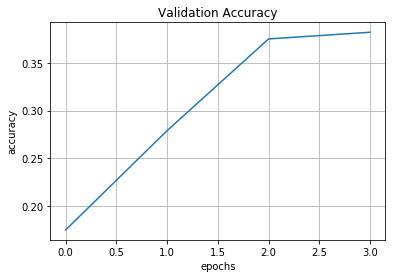

Starting epoch 5 / 90
t = 10, loss = 1.3781
t = 20, loss = 1.3207
t = 30, loss = 1.3318
t = 40, loss = 1.2305
t = 50, loss = 1.2905
t = 60, loss = 1.3202
t = 70, loss = 1.2535
Checking accuracy on validation set
Got 419 / 1000 correct (41.90)


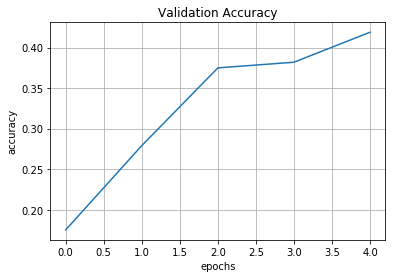

Starting epoch 6 / 90
t = 10, loss = 1.2620
t = 20, loss = 1.1220
t = 30, loss = 1.2282
t = 40, loss = 1.0978
t = 50, loss = 1.1630
t = 60, loss = 1.0961
t = 70, loss = 1.0768
Checking accuracy on validation set
Got 572 / 1000 correct (57.20)


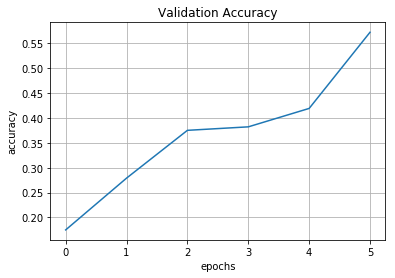

Starting epoch 7 / 90
t = 10, loss = 1.0691
t = 20, loss = 0.9689
t = 30, loss = 1.0287
t = 40, loss = 0.9327
t = 50, loss = 1.0045
t = 60, loss = 0.9421
t = 70, loss = 0.9306
Checking accuracy on validation set
Got 589 / 1000 correct (58.90)


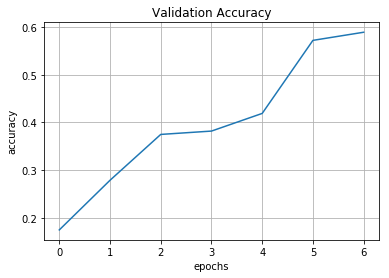

Starting epoch 8 / 90
t = 10, loss = 0.8969
t = 20, loss = 0.8439
t = 30, loss = 0.9184
t = 40, loss = 0.7930
t = 50, loss = 0.8821
t = 60, loss = 0.8758
t = 70, loss = 0.8421
Checking accuracy on validation set
Got 576 / 1000 correct (57.60)


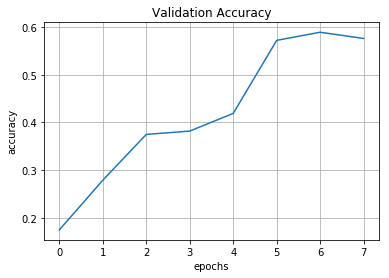

Starting epoch 9 / 90
t = 10, loss = 0.9242
t = 20, loss = 0.8382
t = 30, loss = 0.9078
t = 40, loss = 0.7554
t = 50, loss = 0.8088
t = 60, loss = 0.7886
t = 70, loss = 0.7773
Checking accuracy on validation set
Got 616 / 1000 correct (61.60)


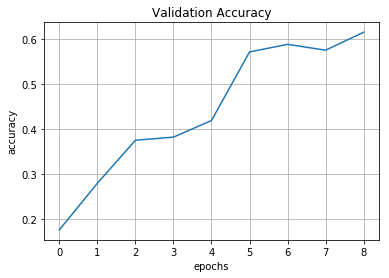

Starting epoch 10 / 90
t = 10, loss = 0.7237
t = 20, loss = 0.7020
t = 30, loss = 0.7412
t = 40, loss = 0.6711
t = 50, loss = 0.6981
t = 60, loss = 0.7078
t = 70, loss = 0.6834
Checking accuracy on validation set
Got 729 / 1000 correct (72.90)


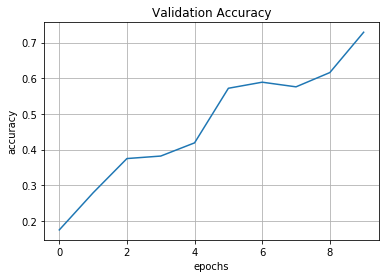

Starting epoch 11 / 90
t = 10, loss = 0.6223
t = 20, loss = 0.6153
t = 30, loss = 0.6737
t = 40, loss = 0.6089
t = 50, loss = 0.6065
t = 60, loss = 0.6221
t = 70, loss = 0.6242
Checking accuracy on validation set
Got 701 / 1000 correct (70.10)


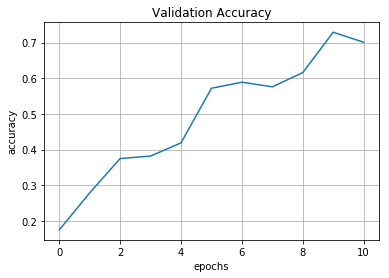

Starting epoch 12 / 90
t = 10, loss = 0.5327
t = 20, loss = 0.5467
t = 30, loss = 0.5703
t = 40, loss = 0.5227
t = 50, loss = 0.5359
t = 60, loss = 0.5654
t = 70, loss = 0.5515
Checking accuracy on validation set
Got 748 / 1000 correct (74.80)


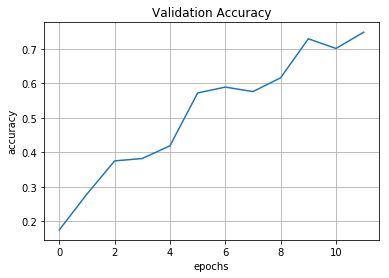

Starting epoch 13 / 90
t = 10, loss = 0.5107
t = 20, loss = 0.5168
t = 30, loss = 0.4813
t = 40, loss = 0.4817
t = 50, loss = 0.5517
t = 60, loss = 0.5175
t = 70, loss = 0.5158
Checking accuracy on validation set
Got 766 / 1000 correct (76.60)


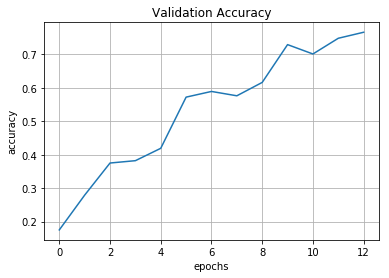

Starting epoch 14 / 90
t = 10, loss = 0.4430
t = 20, loss = 0.4658
t = 30, loss = 0.4807
t = 40, loss = 0.4233
t = 50, loss = 0.5125
t = 60, loss = 0.4959
t = 70, loss = 0.4883
Checking accuracy on validation set
Got 764 / 1000 correct (76.40)


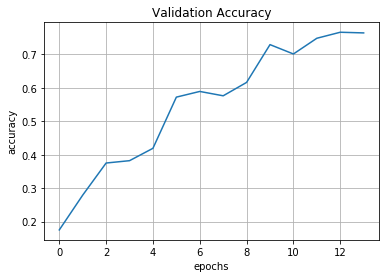

Starting epoch 15 / 90
t = 10, loss = 0.3942
t = 20, loss = 0.4214
t = 30, loss = 0.4109
t = 40, loss = 0.3757
t = 50, loss = 0.4583
t = 60, loss = 0.4763
t = 70, loss = 0.4809
Checking accuracy on validation set
Got 761 / 1000 correct (76.10)


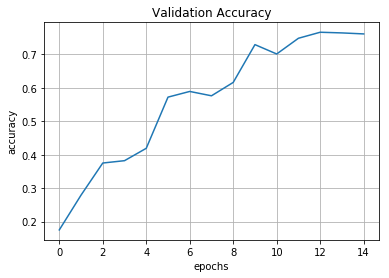

Starting epoch 16 / 90
t = 10, loss = 0.3689
t = 20, loss = 0.3914
t = 30, loss = 0.4036
t = 40, loss = 0.3377
t = 50, loss = 0.4365
t = 60, loss = 0.3907
t = 70, loss = 0.4492
Checking accuracy on validation set
Got 805 / 1000 correct (80.50)


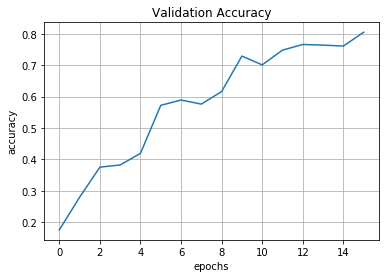

Starting epoch 17 / 90
t = 10, loss = 0.3364
t = 20, loss = 0.3319
t = 30, loss = 0.3348
t = 40, loss = 0.3338
t = 50, loss = 0.3979
t = 60, loss = 0.3850
t = 70, loss = 0.3724
Checking accuracy on validation set
Got 809 / 1000 correct (80.90)


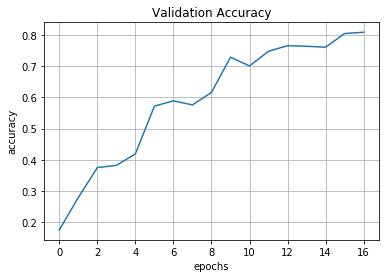

Starting epoch 18 / 90
t = 10, loss = 0.3257
t = 20, loss = 0.3143
t = 30, loss = 0.3107
t = 40, loss = 0.3111
t = 50, loss = 0.4224
t = 60, loss = 0.3299
t = 70, loss = 0.3794
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)


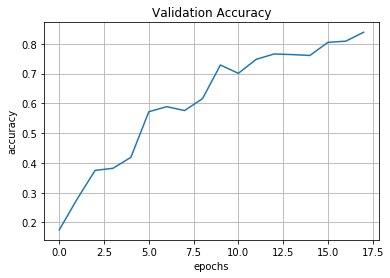

Starting epoch 19 / 90
t = 10, loss = 0.2904
t = 20, loss = 0.2857
t = 30, loss = 0.3130
t = 40, loss = 0.2845
t = 50, loss = 0.3679
t = 60, loss = 0.3365
t = 70, loss = 0.3543
Checking accuracy on validation set
Got 819 / 1000 correct (81.90)


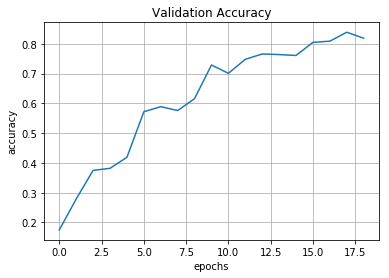

Starting epoch 20 / 90
t = 10, loss = 0.2703
t = 20, loss = 0.3045
t = 30, loss = 0.3165
t = 40, loss = 0.2855
t = 50, loss = 0.3385
t = 60, loss = 0.3097
t = 70, loss = 0.3250
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)


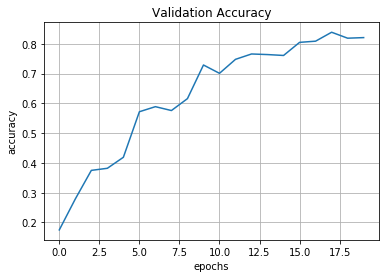

Starting epoch 21 / 90
t = 10, loss = 0.3056
t = 20, loss = 0.2251
t = 30, loss = 0.2221
t = 40, loss = 0.2859
t = 50, loss = 0.3176
t = 60, loss = 0.2934
t = 70, loss = 0.3132
Checking accuracy on validation set
Got 787 / 1000 correct (78.70)


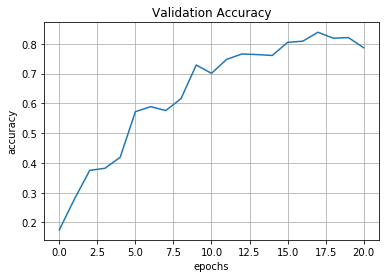

Starting epoch 22 / 90
t = 10, loss = 0.2257
t = 20, loss = 0.2409
t = 30, loss = 0.2604
t = 40, loss = 0.2249
t = 50, loss = 0.3115
t = 60, loss = 0.2581
t = 70, loss = 0.2845
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)


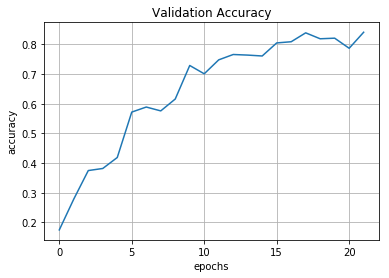

Starting epoch 23 / 90
t = 10, loss = 0.2122
t = 20, loss = 0.2228
t = 30, loss = 0.2484
t = 40, loss = 0.1987
t = 50, loss = 0.3092
t = 60, loss = 0.2588
t = 70, loss = 0.2705
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)


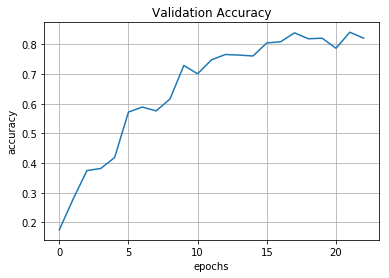

Starting epoch 24 / 90
t = 10, loss = 0.2309
t = 20, loss = 0.2051
t = 30, loss = 0.2509
t = 40, loss = 0.2150
t = 50, loss = 0.2822
t = 60, loss = 0.2436
t = 70, loss = 0.2514
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)


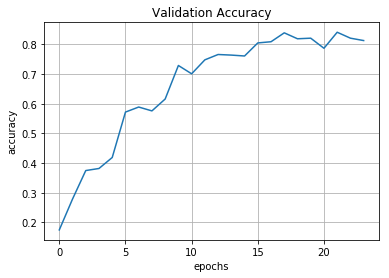

Starting epoch 25 / 90
t = 10, loss = 0.1734
t = 20, loss = 0.1925
t = 30, loss = 0.2192
t = 40, loss = 0.1912
t = 50, loss = 0.2506
t = 60, loss = 0.2241
t = 70, loss = 0.2185
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)


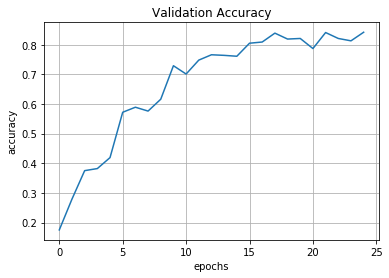

Starting epoch 26 / 90
t = 10, loss = 0.1838
t = 20, loss = 0.1939
t = 30, loss = 0.2260
t = 40, loss = 0.1691
t = 50, loss = 0.2431
t = 60, loss = 0.2056
t = 70, loss = 0.2412
Checking accuracy on validation set
Got 834 / 1000 correct (83.40)


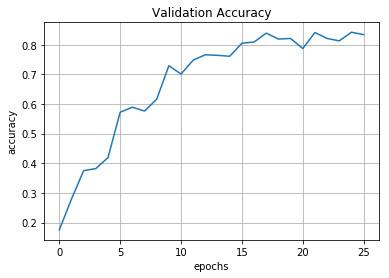

Starting epoch 27 / 90
t = 10, loss = 0.1849
t = 20, loss = 0.2129
t = 30, loss = 0.2063
t = 40, loss = 0.1710
t = 50, loss = 0.2412
t = 60, loss = 0.1942
t = 70, loss = 0.2428
Checking accuracy on validation set
Got 826 / 1000 correct (82.60)


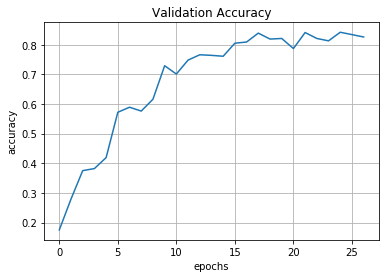

Starting epoch 28 / 90
t = 10, loss = 0.1505
t = 20, loss = 0.1796
t = 30, loss = 0.1777
t = 40, loss = 0.1759
t = 50, loss = 0.2230
t = 60, loss = 0.1901
t = 70, loss = 0.2254
Checking accuracy on validation set
Got 851 / 1000 correct (85.10)


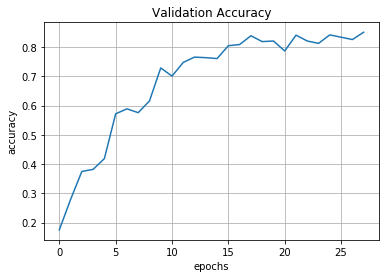

Starting epoch 29 / 90
t = 10, loss = 0.1316
t = 20, loss = 0.1525
t = 30, loss = 0.1766
t = 40, loss = 0.1459
t = 50, loss = 0.2043
t = 60, loss = 0.1974
t = 70, loss = 0.2118
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)


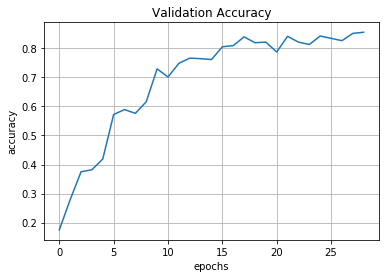

Starting epoch 30 / 90
t = 10, loss = 0.1721
t = 20, loss = 0.1604
t = 30, loss = 0.1920
t = 40, loss = 0.1415
t = 50, loss = 0.2144
t = 60, loss = 0.1554
t = 70, loss = 0.1948
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)


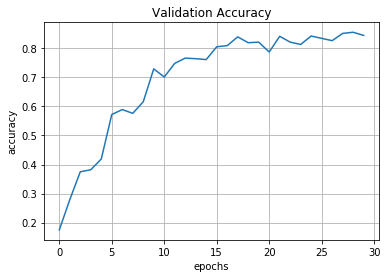

Starting epoch 31 / 90
t = 10, loss = 0.1365
t = 20, loss = 0.1298
t = 30, loss = 0.1383
t = 40, loss = 0.1547
t = 50, loss = 0.1899
t = 60, loss = 0.1271
t = 70, loss = 0.1430
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)


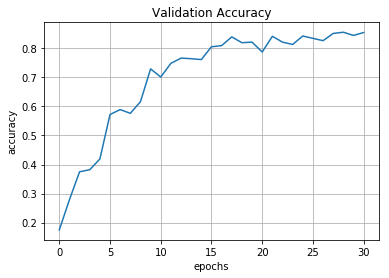

Starting epoch 32 / 90
t = 10, loss = 0.1534
t = 20, loss = 0.1808
t = 30, loss = 0.1663
t = 40, loss = 0.1407
t = 50, loss = 0.1689
t = 60, loss = 0.1502
t = 70, loss = 0.1505
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)


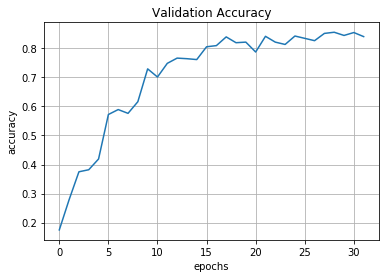

Starting epoch 33 / 90
t = 10, loss = 0.1232
t = 20, loss = 0.1247
t = 30, loss = 0.1440
t = 40, loss = 0.1178
t = 50, loss = 0.2195
t = 60, loss = 0.1227
t = 70, loss = 0.1514
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)


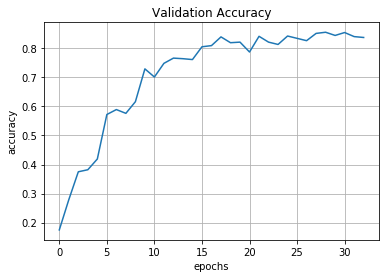

Starting epoch 34 / 90
t = 10, loss = 0.1225
t = 20, loss = 0.1186
t = 30, loss = 0.1511
t = 40, loss = 0.1329
t = 50, loss = 0.1796
t = 60, loss = 0.1060
t = 70, loss = 0.1594
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)


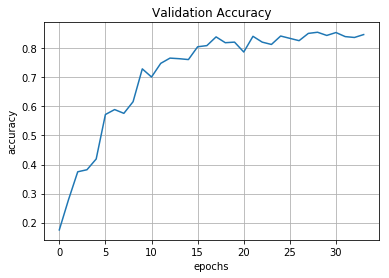

Starting epoch 35 / 90
t = 10, loss = 0.1470
t = 20, loss = 0.1017
t = 30, loss = 0.1351
t = 40, loss = 0.0981
t = 50, loss = 0.1325
t = 60, loss = 0.1069
t = 70, loss = 0.1600
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


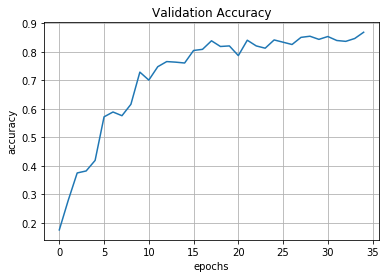

Starting epoch 36 / 90
t = 10, loss = 0.1108
t = 20, loss = 0.1257
t = 30, loss = 0.1340
t = 40, loss = 0.1330
t = 50, loss = 0.1271
t = 60, loss = 0.1661
t = 70, loss = 0.1699
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)


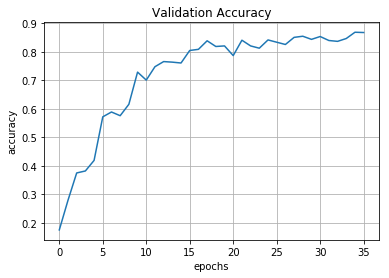

Starting epoch 37 / 90
t = 10, loss = 0.1059
t = 20, loss = 0.1124
t = 30, loss = 0.1181
t = 40, loss = 0.0908
t = 50, loss = 0.1416
t = 60, loss = 0.1170
t = 70, loss = 0.1305
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)


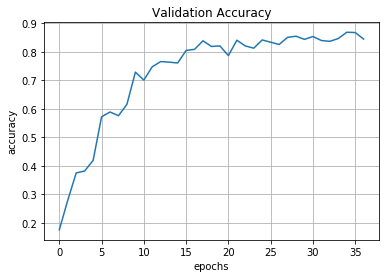

Starting epoch 38 / 90
t = 10, loss = 0.1208
t = 20, loss = 0.1089
t = 30, loss = 0.1177
t = 40, loss = 0.0902
t = 50, loss = 0.1345
t = 60, loss = 0.1135
t = 70, loss = 0.1327
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)


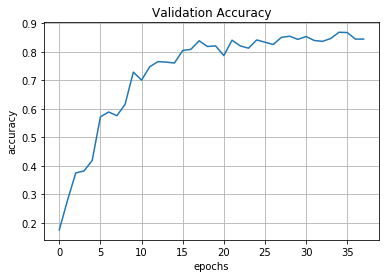

Starting epoch 39 / 90
t = 10, loss = 0.0853
t = 20, loss = 0.0724
t = 30, loss = 0.1096
t = 40, loss = 0.0934
t = 50, loss = 0.1618
t = 60, loss = 0.1027
t = 70, loss = 0.1433
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)


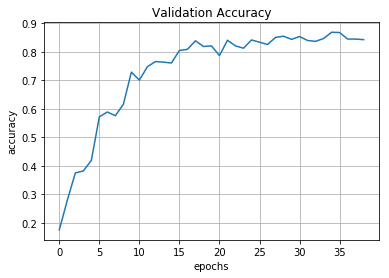

Starting epoch 40 / 90
t = 10, loss = 0.1045
t = 20, loss = 0.1182
t = 30, loss = 0.0873
t = 40, loss = 0.0753
t = 50, loss = 0.0976
t = 60, loss = 0.0981
t = 70, loss = 0.1231
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)


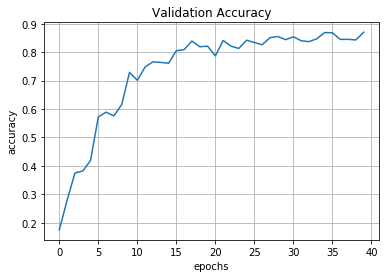

Starting epoch 41 / 90
t = 10, loss = 0.0832
t = 20, loss = 0.0792
t = 30, loss = 0.0969
t = 40, loss = 0.0886
t = 50, loss = 0.1141
t = 60, loss = 0.0885
t = 70, loss = 0.0973
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)


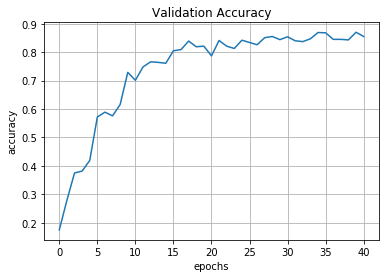

Starting epoch 42 / 90
t = 10, loss = 0.0888
t = 20, loss = 0.0976
t = 30, loss = 0.1213
t = 40, loss = 0.1187
t = 50, loss = 0.1105
t = 60, loss = 0.1191
t = 70, loss = 0.1196
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)


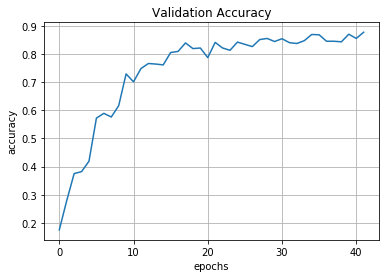

Starting epoch 43 / 90
t = 10, loss = 0.0627
t = 20, loss = 0.0656
t = 30, loss = 0.0980
t = 40, loss = 0.0799
t = 50, loss = 0.0834
t = 60, loss = 0.1171
t = 70, loss = 0.1345
Checking accuracy on validation set
Got 814 / 1000 correct (81.40)


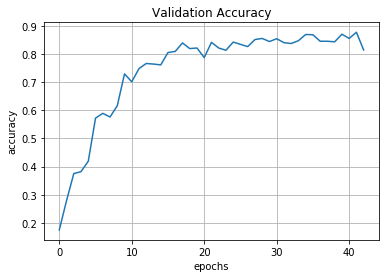

Starting epoch 44 / 90
t = 10, loss = 0.1160
t = 20, loss = 0.0760
t = 30, loss = 0.0971
t = 40, loss = 0.0530
t = 50, loss = 0.1183
t = 60, loss = 0.0851
t = 70, loss = 0.1112
Checking accuracy on validation set
Got 876 / 1000 correct (87.60)


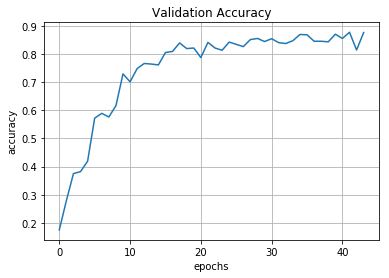

Starting epoch 45 / 90
t = 10, loss = 0.0618
t = 20, loss = 0.1047
t = 30, loss = 0.0799
t = 40, loss = 0.0850
t = 50, loss = 0.1062
t = 60, loss = 0.0828
t = 70, loss = 0.0734
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)


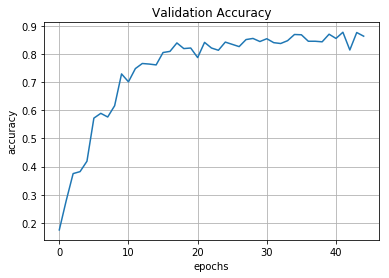

Starting epoch 46 / 90
t = 10, loss = 0.0822
t = 20, loss = 0.0786
t = 30, loss = 0.0754
t = 40, loss = 0.0595
t = 50, loss = 0.0859
t = 60, loss = 0.0702
t = 70, loss = 0.0768
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)


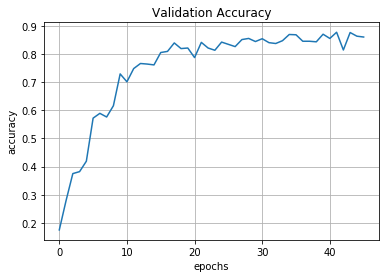

Starting epoch 47 / 90
t = 10, loss = 0.0639
t = 20, loss = 0.0861
t = 30, loss = 0.0731
t = 40, loss = 0.0829
t = 50, loss = 0.1096
t = 60, loss = 0.0827
t = 70, loss = 0.1019
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


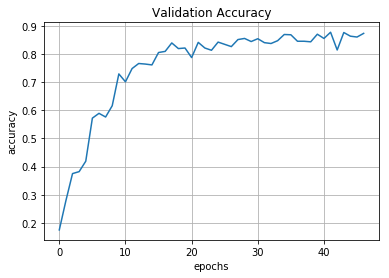

Starting epoch 48 / 90
t = 10, loss = 0.0436
t = 20, loss = 0.0742
t = 30, loss = 0.0583
t = 40, loss = 0.0468
t = 50, loss = 0.0825
t = 60, loss = 0.0953
t = 70, loss = 0.0770
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)


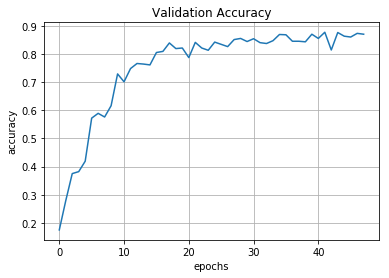

Starting epoch 49 / 90
t = 10, loss = 0.0844
t = 20, loss = 0.0708
t = 30, loss = 0.1000
t = 40, loss = 0.0768
t = 50, loss = 0.1069
t = 60, loss = 0.0791
t = 70, loss = 0.0640
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)


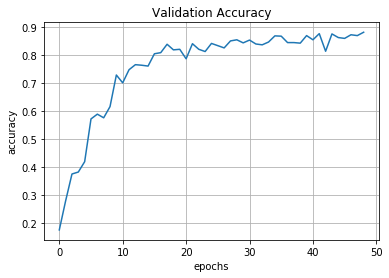

Starting epoch 50 / 90
t = 10, loss = 0.0571
t = 20, loss = 0.0975
t = 30, loss = 0.0582
t = 40, loss = 0.0344
t = 50, loss = 0.0813
t = 60, loss = 0.0543
t = 70, loss = 0.0692
Checking accuracy on validation set
Got 882 / 1000 correct (88.20)


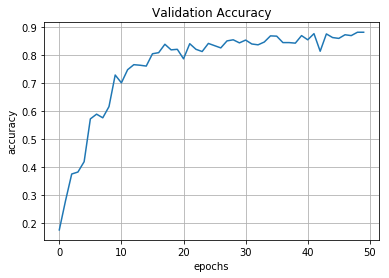

Starting epoch 51 / 90
t = 10, loss = 0.0633
t = 20, loss = 0.0503
t = 30, loss = 0.0682
t = 40, loss = 0.0598
t = 50, loss = 0.1054
t = 60, loss = 0.0709
t = 70, loss = 0.0883
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)


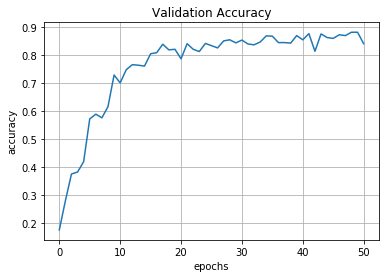

Starting epoch 52 / 90
t = 10, loss = 0.1001
t = 20, loss = 0.0700
t = 30, loss = 0.0793
t = 40, loss = 0.0596
t = 50, loss = 0.0799
t = 60, loss = 0.0800
t = 70, loss = 0.0530
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)


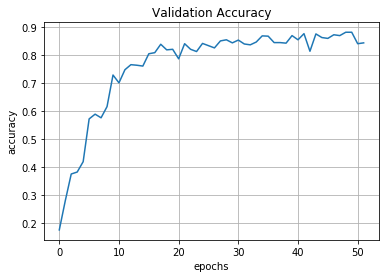

Starting epoch 53 / 90
t = 10, loss = 0.0787
t = 20, loss = 0.0653
t = 30, loss = 0.0809
t = 40, loss = 0.0617
t = 50, loss = 0.1112
t = 60, loss = 0.0705
t = 70, loss = 0.0838
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)


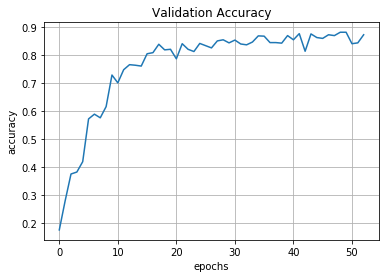

Starting epoch 54 / 90
t = 10, loss = 0.0340
t = 20, loss = 0.0618
t = 30, loss = 0.0741
t = 40, loss = 0.0695
t = 50, loss = 0.0512
t = 60, loss = 0.0614
t = 70, loss = 0.0598
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)


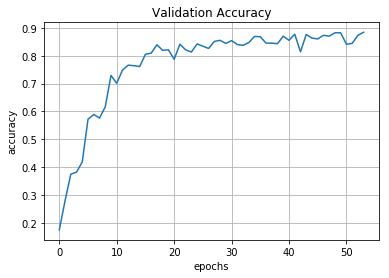

Starting epoch 55 / 90
t = 10, loss = 0.0575
t = 20, loss = 0.0629
t = 30, loss = 0.0571
t = 40, loss = 0.0533
t = 50, loss = 0.0409
t = 60, loss = 0.0500
t = 70, loss = 0.0546
Checking accuracy on validation set
Got 898 / 1000 correct (89.80)


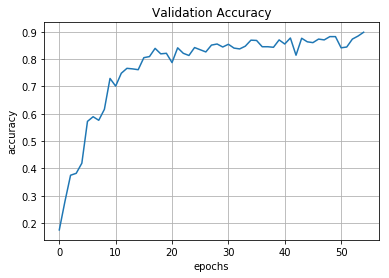

Starting epoch 56 / 90
t = 10, loss = 0.0484
t = 20, loss = 0.0473
t = 30, loss = 0.0496
t = 40, loss = 0.0535
t = 50, loss = 0.0766
t = 60, loss = 0.0643
t = 70, loss = 0.0654
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)


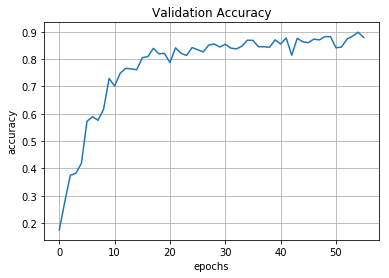

Starting epoch 57 / 90
t = 10, loss = 0.0416
t = 20, loss = 0.0467
t = 30, loss = 0.0563
t = 40, loss = 0.0437
t = 50, loss = 0.0388
t = 60, loss = 0.0785
t = 70, loss = 0.0651
Checking accuracy on validation set
Got 891 / 1000 correct (89.10)


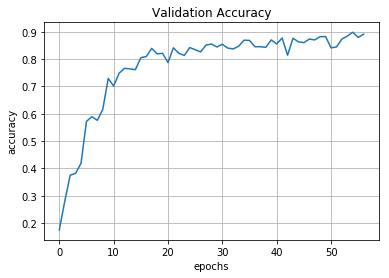

Starting epoch 58 / 90
t = 10, loss = 0.0395
t = 20, loss = 0.0775
t = 30, loss = 0.0755
t = 40, loss = 0.0303
t = 50, loss = 0.0606
t = 60, loss = 0.0622
t = 70, loss = 0.0610
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)


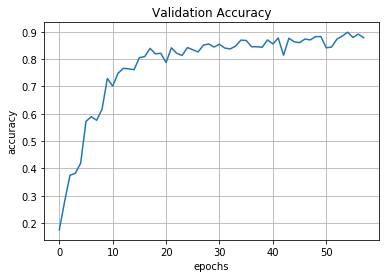

Starting epoch 59 / 90
t = 10, loss = 0.0365
t = 20, loss = 0.0352
t = 30, loss = 0.0417
t = 40, loss = 0.0448
t = 50, loss = 0.0680
t = 60, loss = 0.0517
t = 70, loss = 0.0656
Checking accuracy on validation set
Got 880 / 1000 correct (88.00)


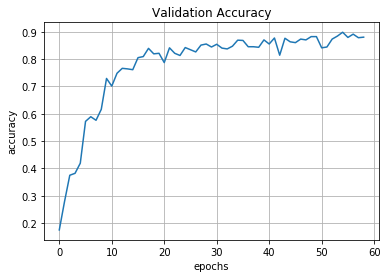

Starting epoch 60 / 90
t = 10, loss = 0.0893
t = 20, loss = 0.0645
t = 30, loss = 0.0575
t = 40, loss = 0.0560
t = 50, loss = 0.0538
t = 60, loss = 0.0773
t = 70, loss = 0.0500
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)


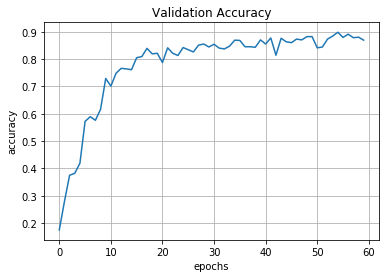

Starting epoch 61 / 90
t = 10, loss = 0.0577
t = 20, loss = 0.0466
t = 30, loss = 0.0672
t = 40, loss = 0.0592
t = 50, loss = 0.0733
t = 60, loss = 0.0603
t = 70, loss = 0.0592
Checking accuracy on validation set
Got 887 / 1000 correct (88.70)


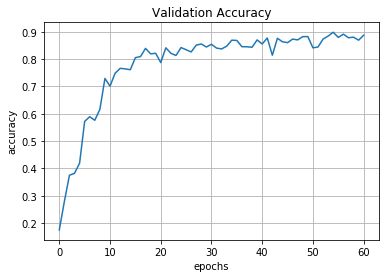

Starting epoch 62 / 90
t = 10, loss = 0.0331
t = 20, loss = 0.0412
t = 30, loss = 0.0568
t = 40, loss = 0.0379
t = 50, loss = 0.0636
t = 60, loss = 0.0399
t = 70, loss = 0.0462
Checking accuracy on validation set
Got 891 / 1000 correct (89.10)


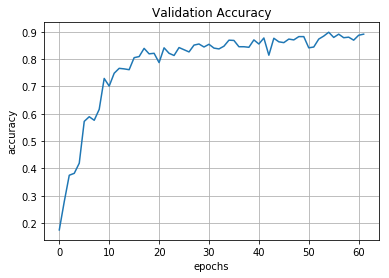

Starting epoch 63 / 90
t = 10, loss = 0.0358
t = 20, loss = 0.0369
t = 30, loss = 0.0243
t = 40, loss = 0.0389
t = 50, loss = 0.0545
t = 60, loss = 0.0395
t = 70, loss = 0.0504
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)


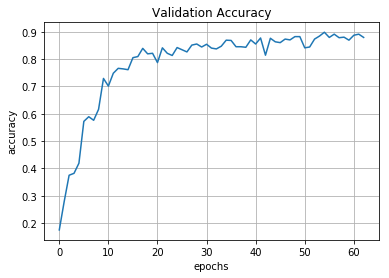

Starting epoch 64 / 90
t = 10, loss = 0.0424
t = 20, loss = 0.0492
t = 30, loss = 0.0422
t = 40, loss = 0.0312
t = 50, loss = 0.0568
t = 60, loss = 0.0446
t = 70, loss = 0.0697
Checking accuracy on validation set
Got 878 / 1000 correct (87.80)


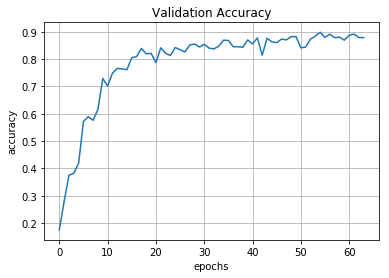

Starting epoch 65 / 90
t = 10, loss = 0.0451
t = 20, loss = 0.0335
t = 30, loss = 0.0394
t = 40, loss = 0.0436
t = 50, loss = 0.0523
t = 60, loss = 0.0441
t = 70, loss = 0.0530
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)


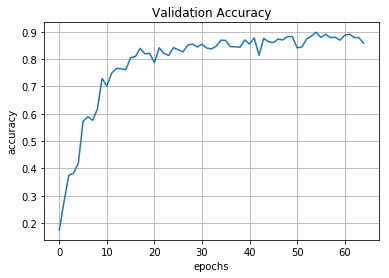

Starting epoch 66 / 90
t = 10, loss = 0.0249
t = 20, loss = 0.0469
t = 30, loss = 0.0364
t = 40, loss = 0.0375
t = 50, loss = 0.0453
t = 60, loss = 0.0335
t = 70, loss = 0.0528
Checking accuracy on validation set
Got 893 / 1000 correct (89.30)


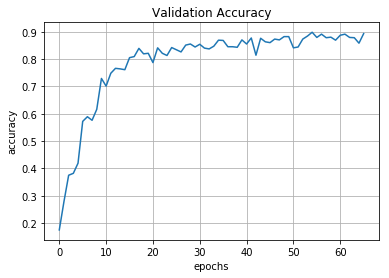

Starting epoch 67 / 90
t = 10, loss = 0.0321
t = 20, loss = 0.0351
t = 30, loss = 0.0495
t = 40, loss = 0.0389
t = 50, loss = 0.0541
t = 60, loss = 0.0419
t = 70, loss = 0.0553
Checking accuracy on validation set
Got 889 / 1000 correct (88.90)


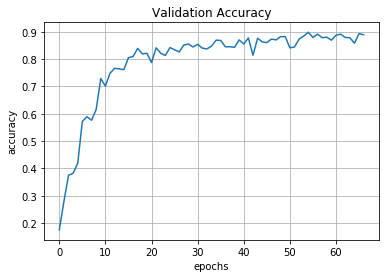

Starting epoch 68 / 90
t = 10, loss = 0.0375
t = 20, loss = 0.0371
t = 30, loss = 0.0546
t = 40, loss = 0.0423
t = 50, loss = 0.0471
t = 60, loss = 0.0432
t = 70, loss = 0.0456
Checking accuracy on validation set
Got 883 / 1000 correct (88.30)


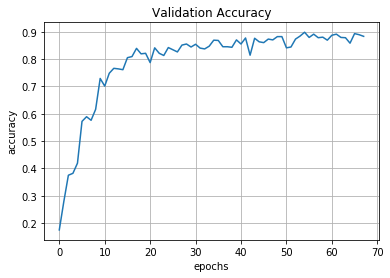

Starting epoch 69 / 90
t = 10, loss = 0.0385
t = 20, loss = 0.0399
t = 30, loss = 0.0544
t = 40, loss = 0.0325
t = 50, loss = 0.0488
t = 60, loss = 0.0409
t = 70, loss = 0.0414
Checking accuracy on validation set
Got 893 / 1000 correct (89.30)


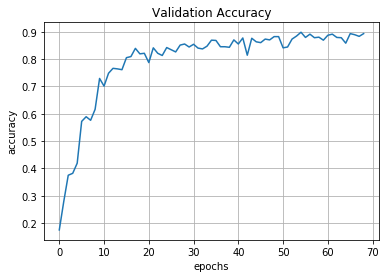

Starting epoch 70 / 90
t = 10, loss = 0.0243
t = 20, loss = 0.0256
t = 30, loss = 0.0508
t = 40, loss = 0.0340
t = 50, loss = 0.0552
t = 60, loss = 0.0363
t = 70, loss = 0.0555
Checking accuracy on validation set
Got 884 / 1000 correct (88.40)


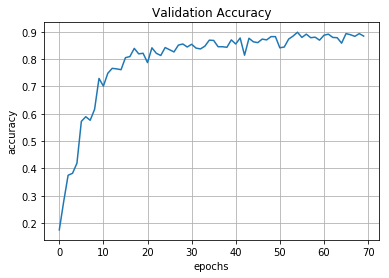

Starting epoch 71 / 90
t = 10, loss = 0.0397
t = 20, loss = 0.0317
t = 30, loss = 0.0373
t = 40, loss = 0.0254
t = 50, loss = 0.0289
t = 60, loss = 0.0451
t = 70, loss = 0.0251
Checking accuracy on validation set
Got 887 / 1000 correct (88.70)


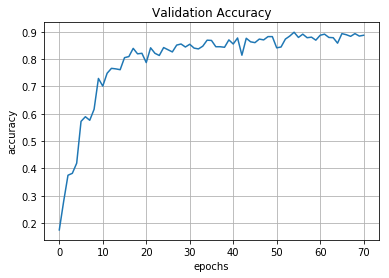

Starting epoch 72 / 90
t = 10, loss = 0.0347
t = 20, loss = 0.0393
t = 30, loss = 0.0446
t = 40, loss = 0.0232
t = 50, loss = 0.0590
t = 60, loss = 0.0664
t = 70, loss = 0.0463
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)


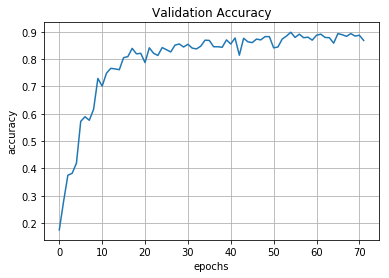

Starting epoch 73 / 90
t = 10, loss = 0.0347
t = 20, loss = 0.0253
t = 30, loss = 0.0256
t = 40, loss = 0.0272
t = 50, loss = 0.0551
t = 60, loss = 0.0414
t = 70, loss = 0.0341
Checking accuracy on validation set
Got 886 / 1000 correct (88.60)


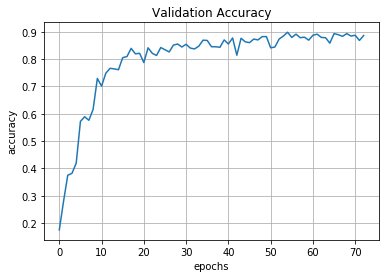

Starting epoch 74 / 90
t = 10, loss = 0.0469
t = 20, loss = 0.0477
t = 30, loss = 0.0499
t = 40, loss = 0.0289
t = 50, loss = 0.0403
t = 60, loss = 0.0293
t = 70, loss = 0.0437
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)


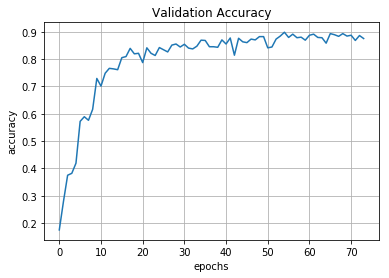

Starting epoch 75 / 90
t = 10, loss = 0.0238
t = 20, loss = 0.0288
t = 30, loss = 0.0421
t = 40, loss = 0.0180
t = 50, loss = 0.0294
t = 60, loss = 0.0427
t = 70, loss = 0.0521
Checking accuracy on validation set
Got 888 / 1000 correct (88.80)


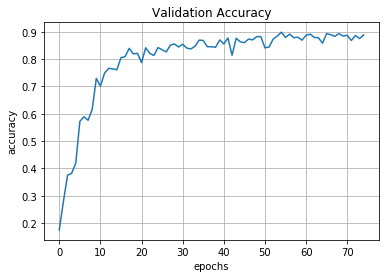

Starting epoch 76 / 90
t = 10, loss = 0.0167
t = 20, loss = 0.0340
t = 30, loss = 0.0486
t = 40, loss = 0.0315
t = 50, loss = 0.0381
t = 60, loss = 0.0389
t = 70, loss = 0.0429
Checking accuracy on validation set
Got 901 / 1000 correct (90.10)


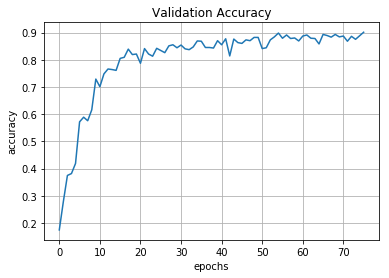

Starting epoch 77 / 90
t = 10, loss = 0.0378
t = 20, loss = 0.0263
t = 30, loss = 0.0345
t = 40, loss = 0.0169
t = 50, loss = 0.0383
t = 60, loss = 0.0312
t = 70, loss = 0.0432
Checking accuracy on validation set
Got 900 / 1000 correct (90.00)


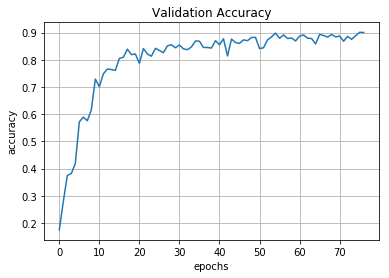

Starting epoch 78 / 90
t = 10, loss = 0.0280
t = 20, loss = 0.0208
t = 30, loss = 0.0259
t = 40, loss = 0.0342
t = 50, loss = 0.0636
t = 60, loss = 0.0400
t = 70, loss = 0.0317
Checking accuracy on validation set
Got 899 / 1000 correct (89.90)


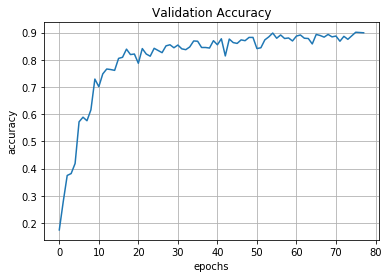

Starting epoch 79 / 90
t = 10, loss = 0.0163
t = 20, loss = 0.0288
t = 30, loss = 0.0286
t = 40, loss = 0.0259
t = 50, loss = 0.0408
t = 60, loss = 0.0578
t = 70, loss = 0.0548
Checking accuracy on validation set
Got 892 / 1000 correct (89.20)


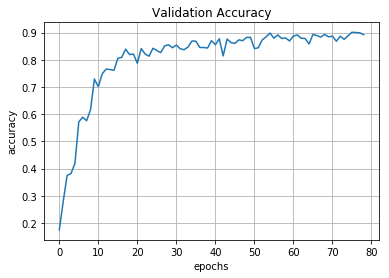

Starting epoch 80 / 90
t = 10, loss = 0.0377
t = 20, loss = 0.0256
t = 30, loss = 0.0372
t = 40, loss = 0.0247
t = 50, loss = 0.0454
t = 60, loss = 0.0521
t = 70, loss = 0.0394
Checking accuracy on validation set
Got 885 / 1000 correct (88.50)


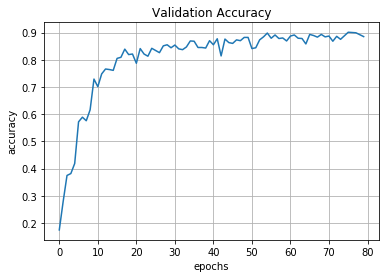

Starting epoch 81 / 90
t = 10, loss = 0.0365
t = 20, loss = 0.0307
t = 30, loss = 0.0280
t = 40, loss = 0.0399
t = 50, loss = 0.0511
t = 60, loss = 0.0308
t = 70, loss = 0.0430
Checking accuracy on validation set
Got 888 / 1000 correct (88.80)


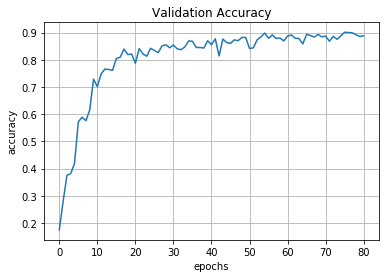

Starting epoch 82 / 90
t = 10, loss = 0.0299
t = 20, loss = 0.0269
t = 30, loss = 0.0245
t = 40, loss = 0.0208
t = 50, loss = 0.0395
t = 60, loss = 0.0469
t = 70, loss = 0.0609
Checking accuracy on validation set
Got 895 / 1000 correct (89.50)


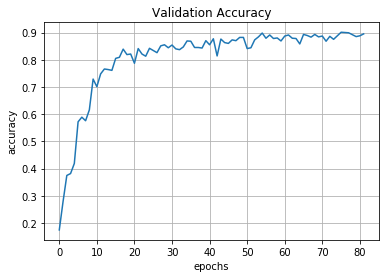

Starting epoch 83 / 90
t = 10, loss = 0.0294
t = 20, loss = 0.0431
t = 30, loss = 0.0410
t = 40, loss = 0.0101
t = 50, loss = 0.0451
t = 60, loss = 0.0333
t = 70, loss = 0.0234
Checking accuracy on validation set
Got 903 / 1000 correct (90.30)


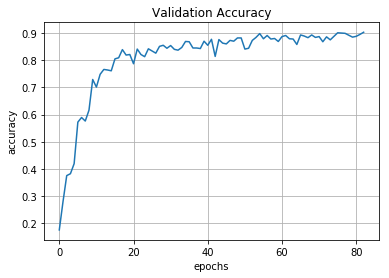

Starting epoch 84 / 90
t = 10, loss = 0.0219
t = 20, loss = 0.0259
t = 30, loss = 0.0234
t = 40, loss = 0.0334
t = 50, loss = 0.0379
t = 60, loss = 0.0248
t = 70, loss = 0.0449
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)


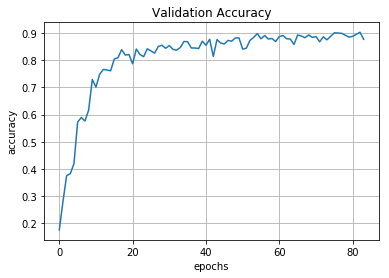

Starting epoch 85 / 90
t = 10, loss = 0.0360
t = 20, loss = 0.0422
t = 30, loss = 0.0322
t = 40, loss = 0.0303
t = 50, loss = 0.0227
t = 60, loss = 0.0451
t = 70, loss = 0.0421
Checking accuracy on validation set
Got 905 / 1000 correct (90.50)


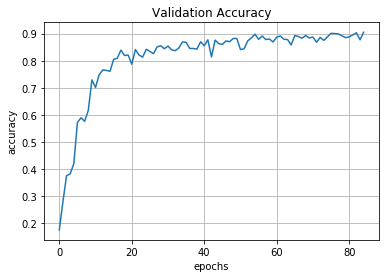

Starting epoch 86 / 90
t = 10, loss = 0.0379
t = 20, loss = 0.0340
t = 30, loss = 0.0278
t = 40, loss = 0.0525
t = 50, loss = 0.0379
t = 60, loss = 0.0212
t = 70, loss = 0.0497
Checking accuracy on validation set
Got 889 / 1000 correct (88.90)


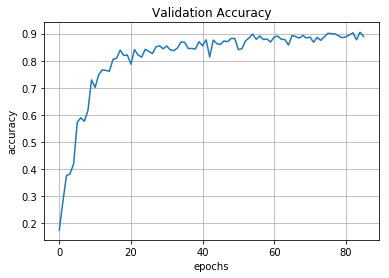

Starting epoch 87 / 90
t = 10, loss = 0.0355
t = 20, loss = 0.0251
t = 30, loss = 0.0329
t = 40, loss = 0.0235
t = 50, loss = 0.0486
t = 60, loss = 0.0331
t = 70, loss = 0.0434
Checking accuracy on validation set
Got 891 / 1000 correct (89.10)


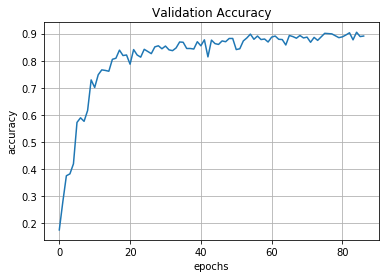

Starting epoch 88 / 90
t = 10, loss = 0.0204
t = 20, loss = 0.0202
t = 30, loss = 0.0178
t = 40, loss = 0.0185
t = 50, loss = 0.0478
t = 60, loss = 0.0150
t = 70, loss = 0.0369
Checking accuracy on validation set
Got 903 / 1000 correct (90.30)


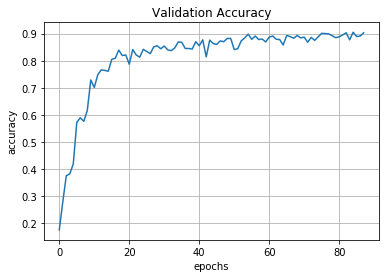

Starting epoch 89 / 90
t = 10, loss = 0.0192
t = 20, loss = 0.0307
t = 30, loss = 0.0286
t = 40, loss = 0.0369
t = 50, loss = 0.0329
t = 60, loss = 0.0385
t = 70, loss = 0.0317
Checking accuracy on validation set
Got 901 / 1000 correct (90.10)


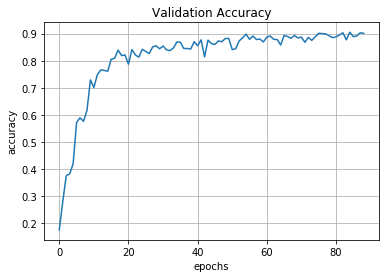

Starting epoch 90 / 90
t = 10, loss = 0.0189
t = 20, loss = 0.0249
t = 30, loss = 0.0157
t = 40, loss = 0.0497
t = 50, loss = 0.0311
t = 60, loss = 0.0373
t = 70, loss = 0.0300
Checking accuracy on validation set
Got 890 / 1000 correct (89.00)


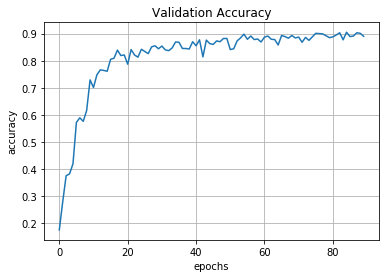

In [11]:
print_every = 10

loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4, nesterov=True)

train(model, loss_fn, optimizer, num_epochs=90)

Starting epoch 1 / 50
t = 10, loss = 0.0297
t = 20, loss = 0.0171
t = 30, loss = 0.0375
t = 40, loss = 0.0090
t = 50, loss = 0.0125
t = 60, loss = 0.0062
t = 70, loss = 0.0057
Checking accuracy on validation set
Got 915 / 1000 correct (91.50)
Starting epoch 2 / 50
t = 10, loss = 0.0028
t = 20, loss = 0.0106
t = 30, loss = 0.0151
t = 40, loss = 0.0041
t = 50, loss = 0.0067
t = 60, loss = 0.0044
t = 70, loss = 0.0073
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)
Starting epoch 3 / 50
t = 10, loss = 0.0014
t = 20, loss = 0.0076
t = 30, loss = 0.0047
t = 40, loss = 0.0030
t = 50, loss = 0.0037
t = 60, loss = 0.0062
t = 70, loss = 0.0054
Checking accuracy on validation set
Got 911 / 1000 correct (91.10)
Starting epoch 4 / 50
t = 10, loss = 0.0038
t = 20, loss = 0.0074
t = 30, loss = 0.0080
t = 40, loss = 0.0050
t = 50, loss = 0.0011
t = 60, loss = 0.0031
t = 70, loss = 0.0021
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


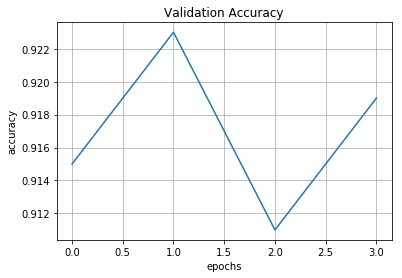

Starting epoch 5 / 50
t = 10, loss = 0.0032
t = 20, loss = 0.0022
t = 30, loss = 0.0035
t = 40, loss = 0.0033
t = 50, loss = 0.0021
t = 60, loss = 0.0067
t = 70, loss = 0.0017
Checking accuracy on validation set
Got 924 / 1000 correct (92.40)


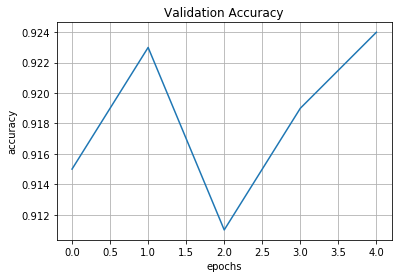

Starting epoch 6 / 50
t = 10, loss = 0.0114
t = 20, loss = 0.0065
t = 30, loss = 0.0017
t = 40, loss = 0.0037
t = 50, loss = 0.0018
t = 60, loss = 0.0010
t = 70, loss = 0.0023
Checking accuracy on validation set
Got 916 / 1000 correct (91.60)


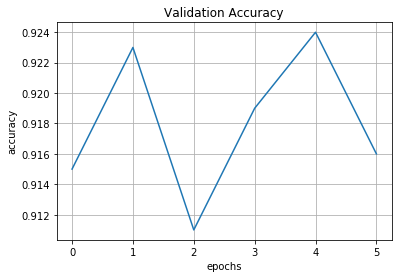

Starting epoch 7 / 50
t = 10, loss = 0.0027
t = 20, loss = 0.0016
t = 30, loss = 0.0026
t = 40, loss = 0.0021
t = 50, loss = 0.0037
t = 60, loss = 0.0019
t = 70, loss = 0.0016
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


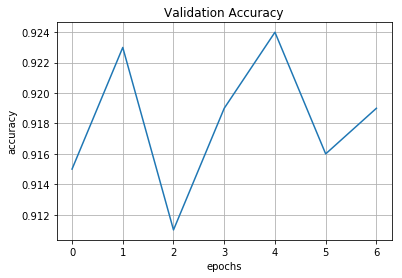

Starting epoch 8 / 50
t = 10, loss = 0.0035
t = 20, loss = 0.0033
t = 30, loss = 0.0021
t = 40, loss = 0.0013
t = 50, loss = 0.0021
t = 60, loss = 0.0018
t = 70, loss = 0.0014
Checking accuracy on validation set
Got 925 / 1000 correct (92.50)


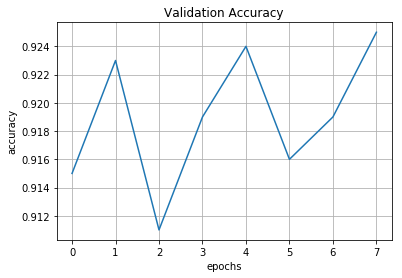

Starting epoch 9 / 50
t = 10, loss = 0.0019
t = 20, loss = 0.0041
t = 30, loss = 0.0029
t = 40, loss = 0.0015
t = 50, loss = 0.0010
t = 60, loss = 0.0013
t = 70, loss = 0.0012
Checking accuracy on validation set
Got 922 / 1000 correct (92.20)


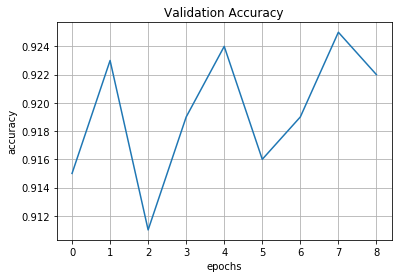

Starting epoch 10 / 50
t = 10, loss = 0.0079
t = 20, loss = 0.0010
t = 30, loss = 0.0022
t = 40, loss = 0.0018
t = 50, loss = 0.0015
t = 60, loss = 0.0010
t = 70, loss = 0.0075
Checking accuracy on validation set
Got 916 / 1000 correct (91.60)


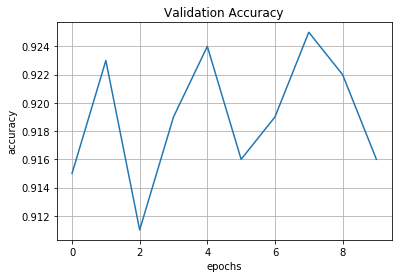

Starting epoch 11 / 50
t = 10, loss = 0.0018
t = 20, loss = 0.0009
t = 30, loss = 0.0031
t = 40, loss = 0.0007
t = 50, loss = 0.0015
t = 60, loss = 0.0008
t = 70, loss = 0.0009
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


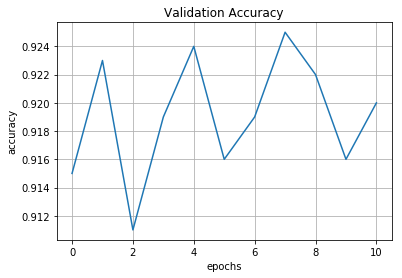

Starting epoch 12 / 50
t = 10, loss = 0.0022
t = 20, loss = 0.0037
t = 30, loss = 0.0015
t = 40, loss = 0.0037
t = 50, loss = 0.0015
t = 60, loss = 0.0015
t = 70, loss = 0.0041
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


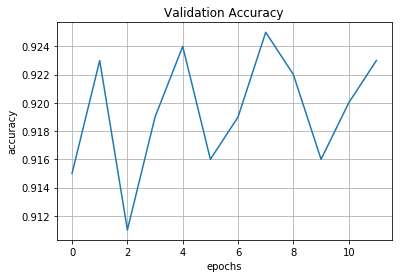

Starting epoch 13 / 50
t = 10, loss = 0.0017
t = 20, loss = 0.0023
t = 30, loss = 0.0011
t = 40, loss = 0.0014
t = 50, loss = 0.0021
t = 60, loss = 0.0035
t = 70, loss = 0.0010
Checking accuracy on validation set
Got 925 / 1000 correct (92.50)


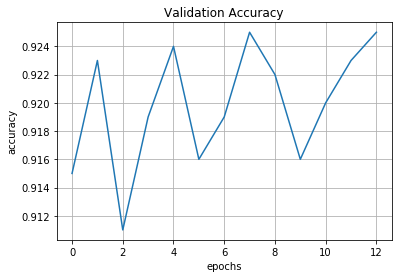

Starting epoch 14 / 50
t = 10, loss = 0.0014
t = 20, loss = 0.0015
t = 30, loss = 0.0019
t = 40, loss = 0.0012
t = 50, loss = 0.0019
t = 60, loss = 0.0027
t = 70, loss = 0.0016
Checking accuracy on validation set
Got 910 / 1000 correct (91.00)


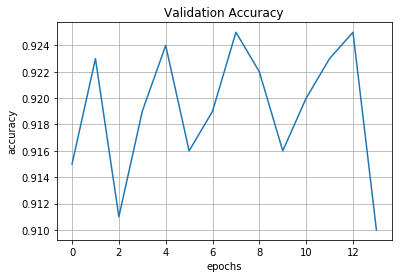

Starting epoch 15 / 50
t = 10, loss = 0.0023
t = 20, loss = 0.0008
t = 30, loss = 0.0014
t = 40, loss = 0.0016
t = 50, loss = 0.0011
t = 60, loss = 0.0008
t = 70, loss = 0.0012
Checking accuracy on validation set
Got 916 / 1000 correct (91.60)


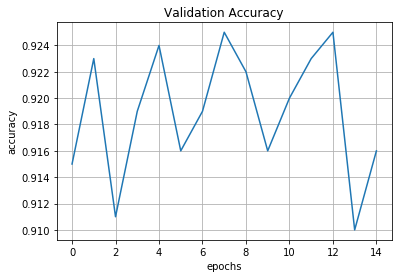

Starting epoch 16 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0044
t = 30, loss = 0.0021
t = 40, loss = 0.0011
t = 50, loss = 0.0020
t = 60, loss = 0.0016
t = 70, loss = 0.0008
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


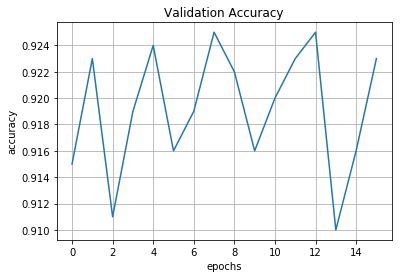

Starting epoch 17 / 50
t = 10, loss = 0.0009
t = 20, loss = 0.0035
t = 30, loss = 0.0023
t = 40, loss = 0.0014
t = 50, loss = 0.0005
t = 60, loss = 0.0007
t = 70, loss = 0.0010
Checking accuracy on validation set
Got 915 / 1000 correct (91.50)


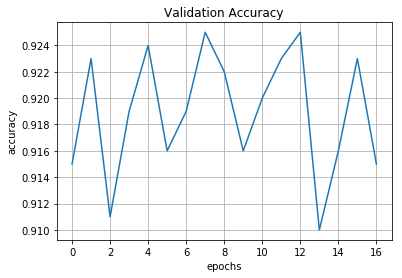

Starting epoch 18 / 50
t = 10, loss = 0.0007
t = 20, loss = 0.0006
t = 30, loss = 0.0009
t = 40, loss = 0.0010
t = 50, loss = 0.0022
t = 60, loss = 0.0006
t = 70, loss = 0.0020
Checking accuracy on validation set
Got 918 / 1000 correct (91.80)


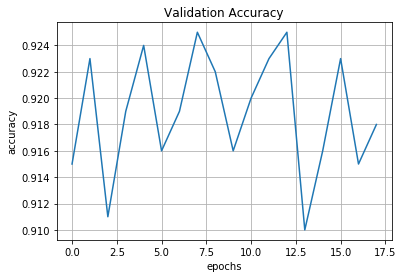

Starting epoch 19 / 50
t = 10, loss = 0.0011
t = 20, loss = 0.0013
t = 30, loss = 0.0013
t = 40, loss = 0.0015
t = 50, loss = 0.0004
t = 60, loss = 0.0008
t = 70, loss = 0.0008
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


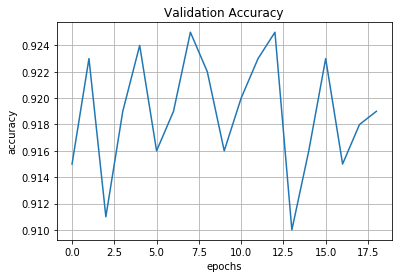

Starting epoch 20 / 50
t = 10, loss = 0.0020
t = 20, loss = 0.0024
t = 30, loss = 0.0011
t = 40, loss = 0.0010
t = 50, loss = 0.0008
t = 60, loss = 0.0003
t = 70, loss = 0.0032
Checking accuracy on validation set
Got 926 / 1000 correct (92.60)


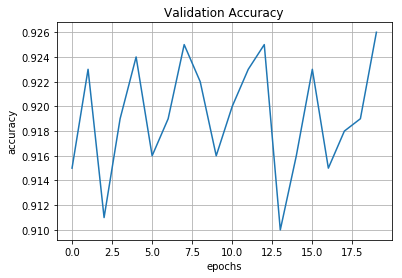

Starting epoch 21 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0013
t = 30, loss = 0.0011
t = 40, loss = 0.0020
t = 50, loss = 0.0008
t = 60, loss = 0.0018
t = 70, loss = 0.0009
Checking accuracy on validation set
Got 925 / 1000 correct (92.50)


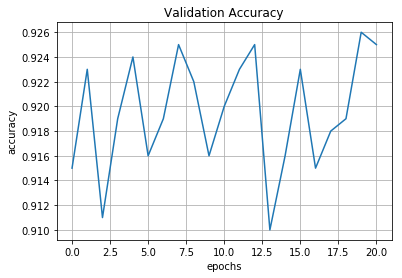

Starting epoch 22 / 50
t = 10, loss = 0.0009
t = 20, loss = 0.0008
t = 30, loss = 0.0006
t = 40, loss = 0.0007
t = 50, loss = 0.0006
t = 60, loss = 0.0009
t = 70, loss = 0.0012
Checking accuracy on validation set
Got 924 / 1000 correct (92.40)


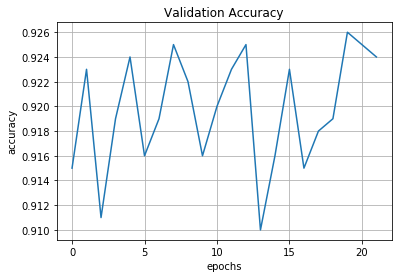

Starting epoch 23 / 50
t = 10, loss = 0.0007
t = 20, loss = 0.0011
t = 30, loss = 0.0011
t = 40, loss = 0.0013
t = 50, loss = 0.0005
t = 60, loss = 0.0009
t = 70, loss = 0.0011
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


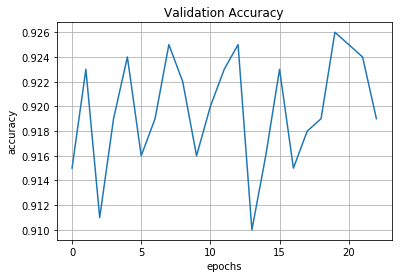

Starting epoch 24 / 50
t = 10, loss = 0.0043
t = 20, loss = 0.0004
t = 30, loss = 0.0010
t = 40, loss = 0.0007
t = 50, loss = 0.0012
t = 60, loss = 0.0005
t = 70, loss = 0.0010
Checking accuracy on validation set
Got 922 / 1000 correct (92.20)


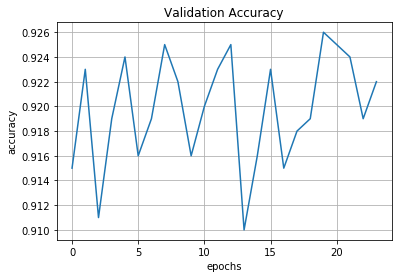

Starting epoch 25 / 50
t = 10, loss = 0.0015
t = 20, loss = 0.0005
t = 30, loss = 0.0006
t = 40, loss = 0.0007
t = 50, loss = 0.0005
t = 60, loss = 0.0004
t = 70, loss = 0.0016
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


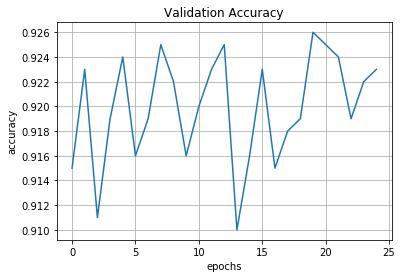

Starting epoch 26 / 50
t = 10, loss = 0.0008
t = 20, loss = 0.0004
t = 30, loss = 0.0006
t = 40, loss = 0.0004
t = 50, loss = 0.0005
t = 60, loss = 0.0005
t = 70, loss = 0.0019
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


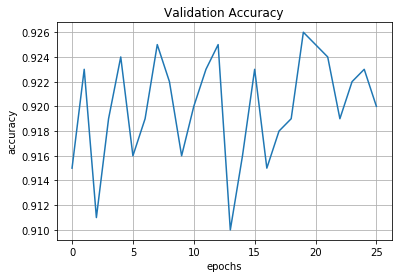

Starting epoch 27 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0004
t = 30, loss = 0.0006
t = 40, loss = 0.0004
t = 50, loss = 0.0020
t = 60, loss = 0.0005
t = 70, loss = 0.0013
Checking accuracy on validation set
Got 924 / 1000 correct (92.40)


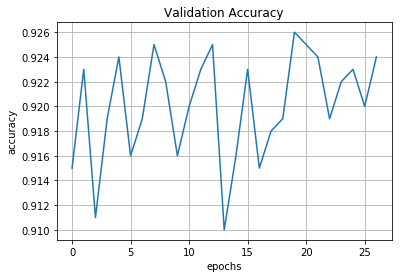

Starting epoch 28 / 50
t = 10, loss = 0.0016
t = 20, loss = 0.0010
t = 30, loss = 0.0004
t = 40, loss = 0.0005
t = 50, loss = 0.0004
t = 60, loss = 0.0007
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


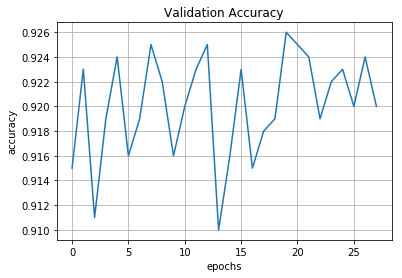

Starting epoch 29 / 50
t = 10, loss = 0.0011
t = 20, loss = 0.0004
t = 30, loss = 0.0012
t = 40, loss = 0.0008
t = 50, loss = 0.0006
t = 60, loss = 0.0015
t = 70, loss = 0.0014
Checking accuracy on validation set
Got 929 / 1000 correct (92.90)


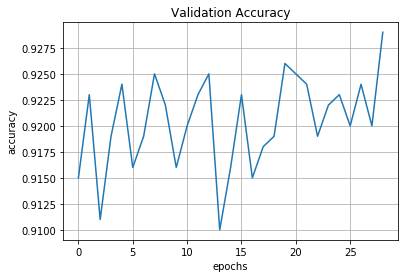

Starting epoch 30 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0008
t = 30, loss = 0.0012
t = 40, loss = 0.0004
t = 50, loss = 0.0003
t = 60, loss = 0.0005
t = 70, loss = 0.0016
Checking accuracy on validation set
Got 928 / 1000 correct (92.80)


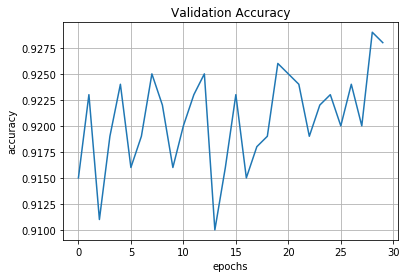

Starting epoch 31 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0008
t = 30, loss = 0.0008
t = 40, loss = 0.0007
t = 50, loss = 0.0005
t = 60, loss = 0.0012
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 921 / 1000 correct (92.10)


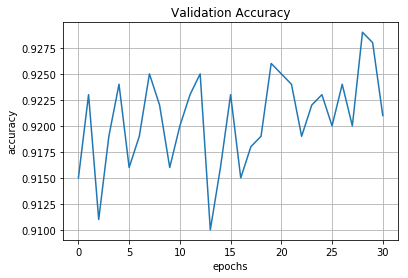

Starting epoch 32 / 50
t = 10, loss = 0.0008
t = 20, loss = 0.0009
t = 30, loss = 0.0005
t = 40, loss = 0.0007
t = 50, loss = 0.0008
t = 60, loss = 0.0005
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 915 / 1000 correct (91.50)


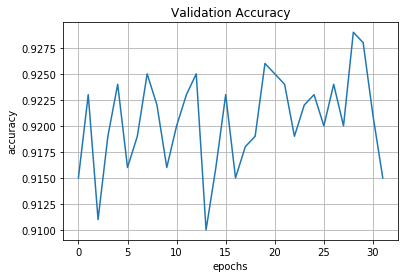

Starting epoch 33 / 50
t = 10, loss = 0.0006
t = 20, loss = 0.0004
t = 30, loss = 0.0006
t = 40, loss = 0.0007
t = 50, loss = 0.0004
t = 60, loss = 0.0007
t = 70, loss = 0.0008
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


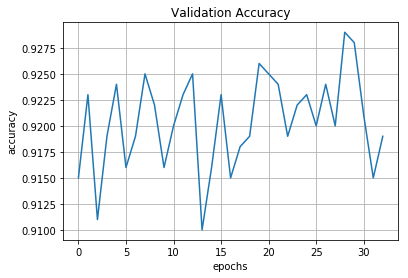

Starting epoch 34 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0022
t = 30, loss = 0.0003
t = 40, loss = 0.0010
t = 50, loss = 0.0005
t = 60, loss = 0.0011
t = 70, loss = 0.0010
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


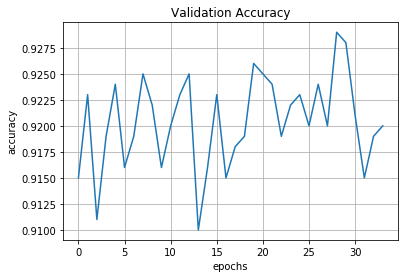

Starting epoch 35 / 50
t = 10, loss = 0.0010
t = 20, loss = 0.0038
t = 30, loss = 0.0007
t = 40, loss = 0.0003
t = 50, loss = 0.0005
t = 60, loss = 0.0002
t = 70, loss = 0.0009
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


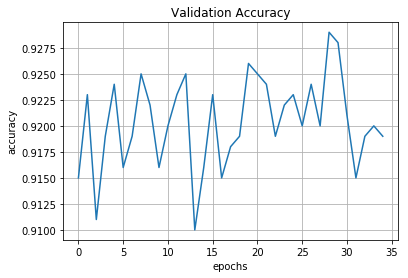

Starting epoch 36 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0006
t = 30, loss = 0.0074
t = 40, loss = 0.0009
t = 50, loss = 0.0006
t = 60, loss = 0.0008
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 916 / 1000 correct (91.60)


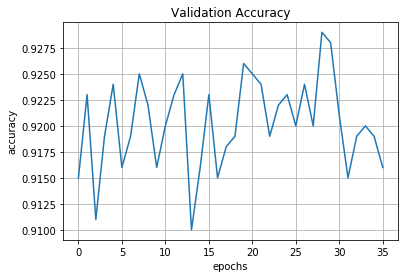

Starting epoch 37 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0006
t = 30, loss = 0.0044
t = 40, loss = 0.0006
t = 50, loss = 0.0020
t = 60, loss = 0.0003
t = 70, loss = 0.0009
Checking accuracy on validation set
Got 924 / 1000 correct (92.40)


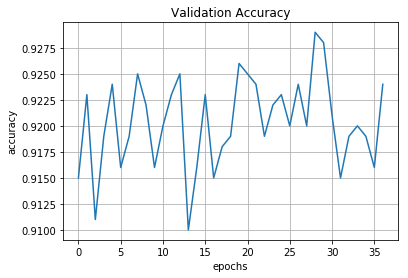

Starting epoch 38 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0006
t = 30, loss = 0.0006
t = 40, loss = 0.0004
t = 50, loss = 0.0005
t = 60, loss = 0.0011
t = 70, loss = 0.0012
Checking accuracy on validation set
Got 931 / 1000 correct (93.10)


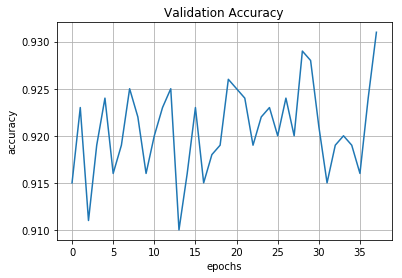

Starting epoch 39 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0009
t = 30, loss = 0.0018
t = 40, loss = 0.0004
t = 50, loss = 0.0011
t = 60, loss = 0.0006
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 913 / 1000 correct (91.30)


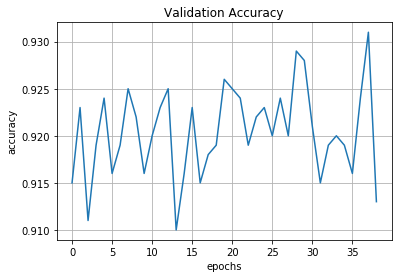

Starting epoch 40 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0006
t = 30, loss = 0.0004
t = 40, loss = 0.0005
t = 50, loss = 0.0009
t = 60, loss = 0.0006
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


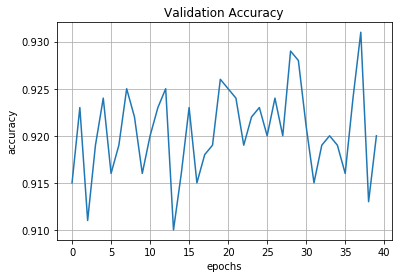

Starting epoch 41 / 50
t = 10, loss = 0.0010
t = 20, loss = 0.0005
t = 30, loss = 0.0003
t = 40, loss = 0.0010
t = 50, loss = 0.0003
t = 60, loss = 0.0005
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 926 / 1000 correct (92.60)


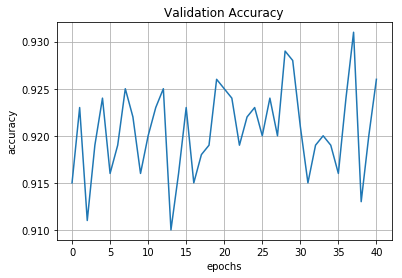

Starting epoch 42 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0010
t = 30, loss = 0.0006
t = 40, loss = 0.0007
t = 50, loss = 0.0003
t = 60, loss = 0.0012
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 927 / 1000 correct (92.70)


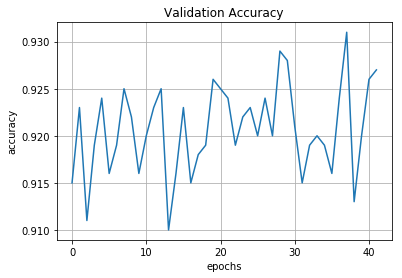

Starting epoch 43 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0004
t = 30, loss = 0.0009
t = 40, loss = 0.0003
t = 50, loss = 0.0004
t = 60, loss = 0.0002
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 922 / 1000 correct (92.20)


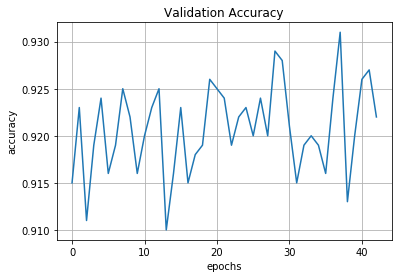

Starting epoch 44 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0004
t = 30, loss = 0.0004
t = 40, loss = 0.0004
t = 50, loss = 0.0007
t = 60, loss = 0.0006
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


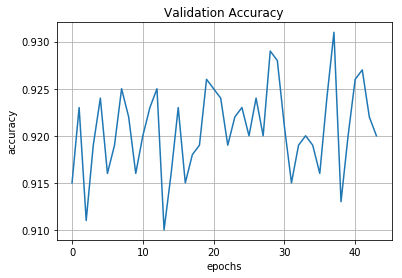

Starting epoch 45 / 50
t = 10, loss = 0.0010
t = 20, loss = 0.0006
t = 30, loss = 0.0032
t = 40, loss = 0.0015
t = 50, loss = 0.0005
t = 60, loss = 0.0010
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


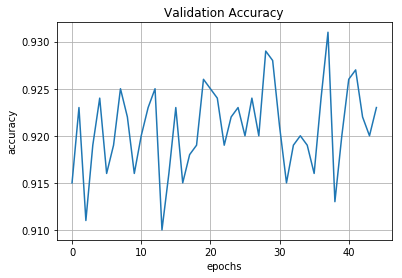

Starting epoch 46 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0007
t = 30, loss = 0.0005
t = 40, loss = 0.0002
t = 50, loss = 0.0007
t = 60, loss = 0.0004
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 917 / 1000 correct (91.70)


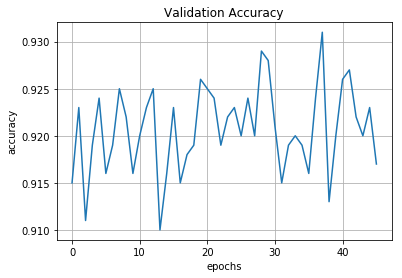

Starting epoch 47 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0003
t = 30, loss = 0.0005
t = 40, loss = 0.0006
t = 50, loss = 0.0008
t = 60, loss = 0.0006
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 929 / 1000 correct (92.90)


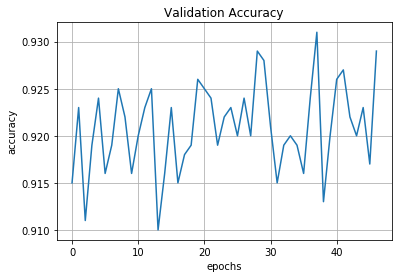

Starting epoch 48 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0009
t = 30, loss = 0.0004
t = 40, loss = 0.0003
t = 50, loss = 0.0006
t = 60, loss = 0.0003
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 913 / 1000 correct (91.30)


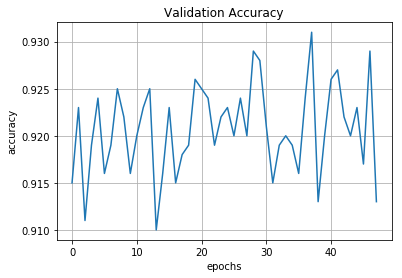

Starting epoch 49 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0007
t = 30, loss = 0.0002
t = 40, loss = 0.0004
t = 50, loss = 0.0004
t = 60, loss = 0.0003
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 922 / 1000 correct (92.20)


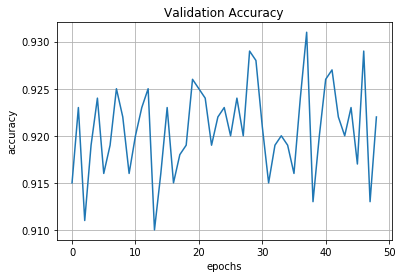

Starting epoch 50 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0006
t = 30, loss = 0.0003
t = 40, loss = 0.0007
t = 50, loss = 0.0005
t = 60, loss = 0.0004
t = 70, loss = 0.0008
Checking accuracy on validation set
Got 915 / 1000 correct (91.50)


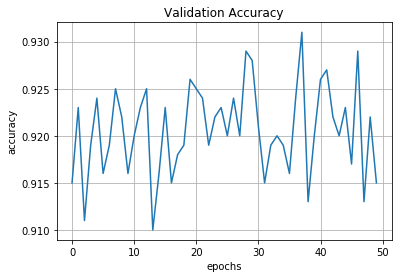

In [12]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4, nesterov=True)

train(model, loss_fn, optimizer, num_epochs=50)

Starting epoch 1 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0005
t = 30, loss = 0.0004
t = 40, loss = 0.0003
t = 50, loss = 0.0011
t = 60, loss = 0.0017
t = 70, loss = 0.0010
Checking accuracy on validation set
Got 921 / 1000 correct (92.10)
Starting epoch 2 / 50
t = 10, loss = 0.0007
t = 20, loss = 0.0006
t = 30, loss = 0.0006
t = 40, loss = 0.0008
t = 50, loss = 0.0003
t = 60, loss = 0.0014
t = 70, loss = 0.0043
Checking accuracy on validation set
Got 933 / 1000 correct (93.30)
Starting epoch 3 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0003
t = 30, loss = 0.0004
t = 40, loss = 0.0005
t = 50, loss = 0.0003
t = 60, loss = 0.0002
t = 70, loss = 0.0074
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)
Starting epoch 4 / 50
t = 10, loss = 0.0028
t = 20, loss = 0.0008
t = 30, loss = 0.0006
t = 40, loss = 0.0003
t = 50, loss = 0.0004
t = 60, loss = 0.0005
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


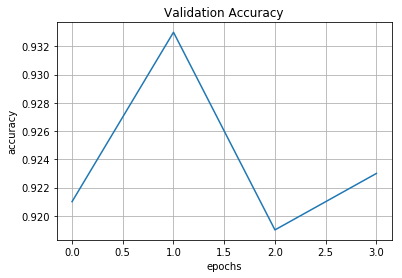

Starting epoch 5 / 50
t = 10, loss = 0.0006
t = 20, loss = 0.0007
t = 30, loss = 0.0007
t = 40, loss = 0.0003
t = 50, loss = 0.0016
t = 60, loss = 0.0021
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 924 / 1000 correct (92.40)


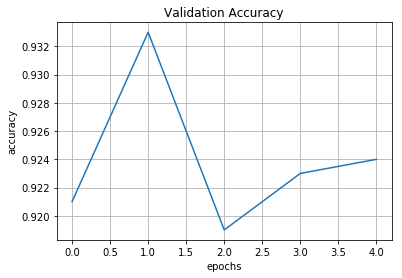

Starting epoch 6 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0005
t = 30, loss = 0.0005
t = 40, loss = 0.0009
t = 50, loss = 0.0002
t = 60, loss = 0.0004
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


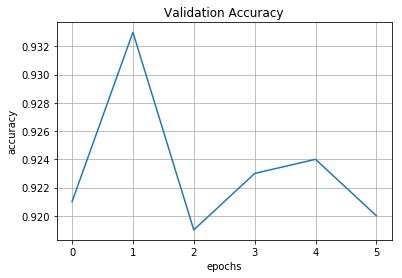

Starting epoch 7 / 50
t = 10, loss = 0.0001
t = 20, loss = 0.0006
t = 30, loss = 0.0004
t = 40, loss = 0.0004
t = 50, loss = 0.0003
t = 60, loss = 0.0003
t = 70, loss = 0.0009
Checking accuracy on validation set
Got 918 / 1000 correct (91.80)


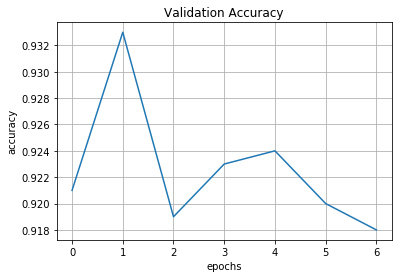

Starting epoch 8 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0005
t = 30, loss = 0.0004
t = 40, loss = 0.0005
t = 50, loss = 0.0005
t = 60, loss = 0.0009
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


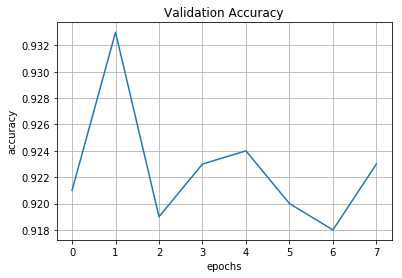

Starting epoch 9 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0006
t = 30, loss = 0.0003
t = 40, loss = 0.0005
t = 50, loss = 0.0004
t = 60, loss = 0.0005
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


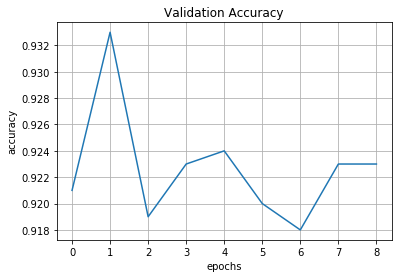

Starting epoch 10 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0003
t = 30, loss = 0.0004
t = 40, loss = 0.0004
t = 50, loss = 0.0004
t = 60, loss = 0.0003
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


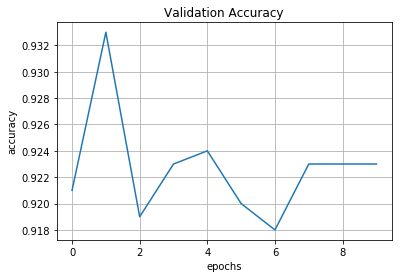

Starting epoch 11 / 50
t = 10, loss = 0.0007
t = 20, loss = 0.0008
t = 30, loss = 0.0012
t = 40, loss = 0.0002
t = 50, loss = 0.0004
t = 60, loss = 0.0005
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 917 / 1000 correct (91.70)


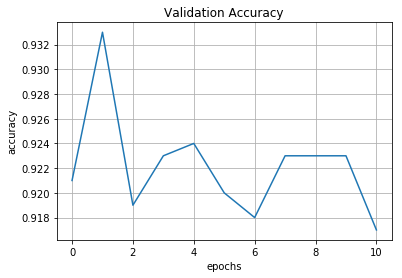

Starting epoch 12 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0005
t = 30, loss = 0.0005
t = 40, loss = 0.0003
t = 50, loss = 0.0007
t = 60, loss = 0.0004
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 928 / 1000 correct (92.80)


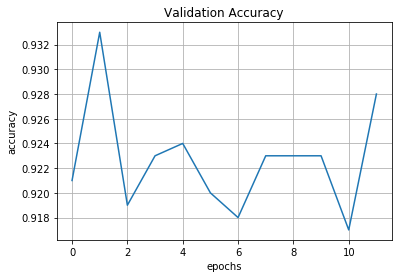

Starting epoch 13 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0007
t = 30, loss = 0.0005
t = 40, loss = 0.0003
t = 50, loss = 0.0013
t = 60, loss = 0.0002
t = 70, loss = 0.0008
Checking accuracy on validation set
Got 918 / 1000 correct (91.80)


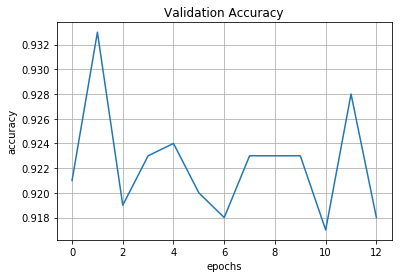

Starting epoch 14 / 50
t = 10, loss = 0.0006
t = 20, loss = 0.0007
t = 30, loss = 0.0005
t = 40, loss = 0.0007
t = 50, loss = 0.0002
t = 60, loss = 0.0004
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 917 / 1000 correct (91.70)


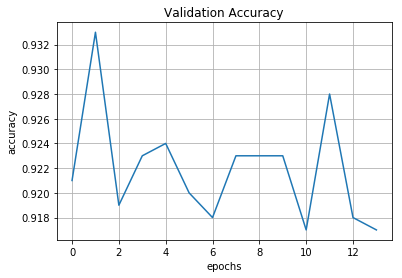

Starting epoch 15 / 50
t = 10, loss = 0.0039
t = 20, loss = 0.0005
t = 30, loss = 0.0005
t = 40, loss = 0.0003
t = 50, loss = 0.0002
t = 60, loss = 0.0003
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 924 / 1000 correct (92.40)


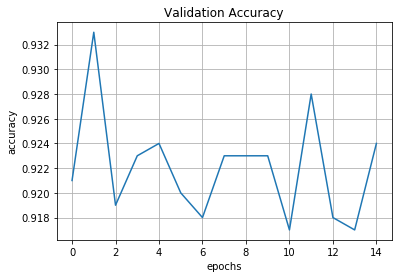

Starting epoch 16 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0006
t = 30, loss = 0.0003
t = 40, loss = 0.0005
t = 50, loss = 0.0004
t = 60, loss = 0.0008
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 926 / 1000 correct (92.60)


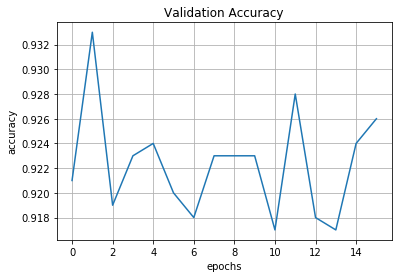

Starting epoch 17 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0003
t = 30, loss = 0.0003
t = 40, loss = 0.0004
t = 50, loss = 0.0019
t = 60, loss = 0.0002
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


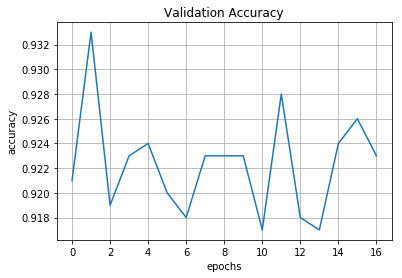

Starting epoch 18 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0005
t = 30, loss = 0.0003
t = 40, loss = 0.0012
t = 50, loss = 0.0003
t = 60, loss = 0.0005
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 928 / 1000 correct (92.80)


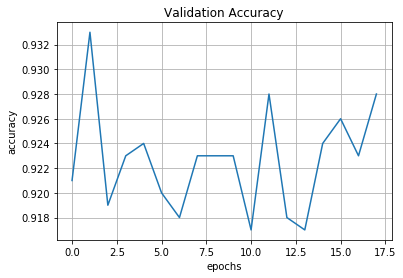

Starting epoch 19 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0003
t = 30, loss = 0.0008
t = 40, loss = 0.0002
t = 50, loss = 0.0005
t = 60, loss = 0.0001
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 918 / 1000 correct (91.80)


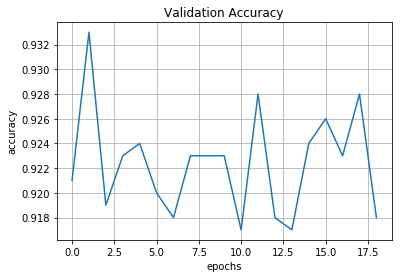

Starting epoch 20 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0002
t = 30, loss = 0.0003
t = 40, loss = 0.0003
t = 50, loss = 0.0004
t = 60, loss = 0.0003
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 924 / 1000 correct (92.40)


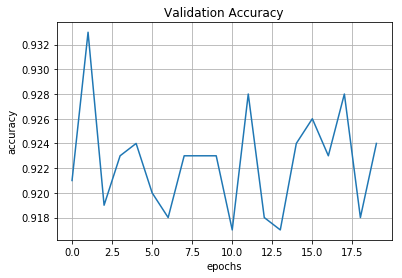

Starting epoch 21 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0005
t = 30, loss = 0.0004
t = 40, loss = 0.0003
t = 50, loss = 0.0003
t = 60, loss = 0.0009
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 928 / 1000 correct (92.80)


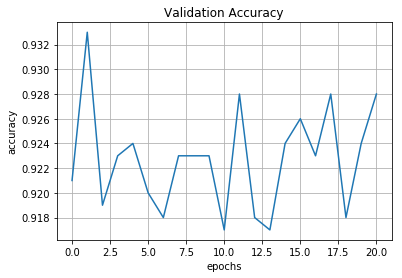

Starting epoch 22 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0007
t = 30, loss = 0.0003
t = 40, loss = 0.0004
t = 50, loss = 0.0006
t = 60, loss = 0.0005
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 921 / 1000 correct (92.10)


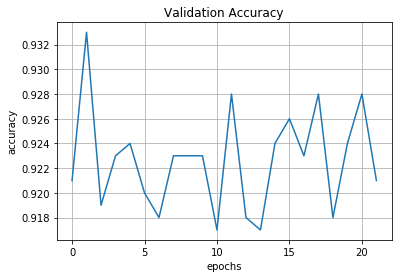

Starting epoch 23 / 50
t = 10, loss = 0.0006
t = 20, loss = 0.0007
t = 30, loss = 0.0003
t = 40, loss = 0.0004
t = 50, loss = 0.0003
t = 60, loss = 0.0004
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 921 / 1000 correct (92.10)


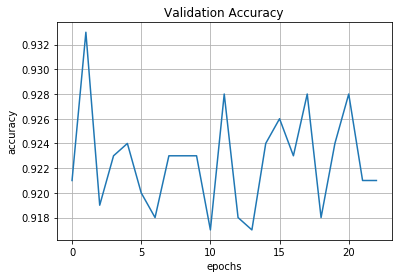

Starting epoch 24 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0004
t = 30, loss = 0.0005
t = 40, loss = 0.0006
t = 50, loss = 0.0007
t = 60, loss = 0.0003
t = 70, loss = 0.0056
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


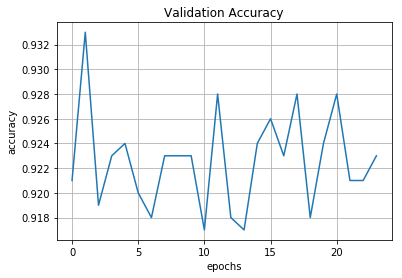

Starting epoch 25 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0004
t = 30, loss = 0.0003
t = 40, loss = 0.0005
t = 50, loss = 0.0004
t = 60, loss = 0.0003
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 928 / 1000 correct (92.80)


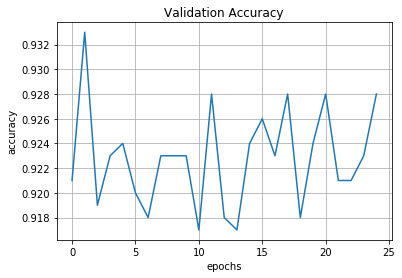

Starting epoch 26 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0006
t = 30, loss = 0.0002
t = 40, loss = 0.0004
t = 50, loss = 0.0002
t = 60, loss = 0.0003
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 927 / 1000 correct (92.70)


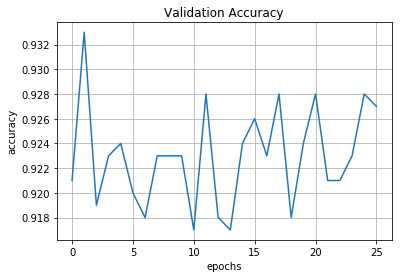

Starting epoch 27 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0005
t = 30, loss = 0.0005
t = 40, loss = 0.0004
t = 50, loss = 0.0005
t = 60, loss = 0.0004
t = 70, loss = 0.0011
Checking accuracy on validation set
Got 925 / 1000 correct (92.50)


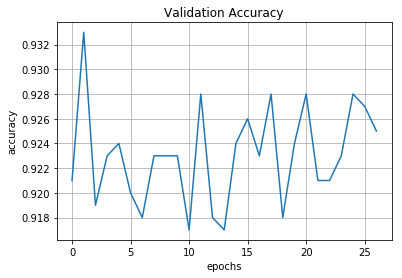

Starting epoch 28 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0007
t = 30, loss = 0.0005
t = 40, loss = 0.0002
t = 50, loss = 0.0009
t = 60, loss = 0.0004
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 914 / 1000 correct (91.40)


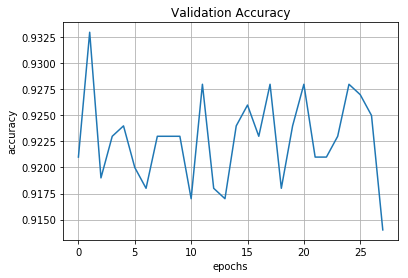

Starting epoch 29 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0004
t = 30, loss = 0.0005
t = 40, loss = 0.0004
t = 50, loss = 0.0004
t = 60, loss = 0.0004
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 930 / 1000 correct (93.00)


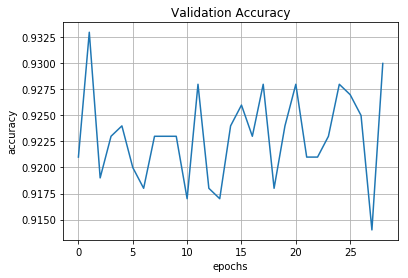

Starting epoch 30 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0003
t = 30, loss = 0.0005
t = 40, loss = 0.0002
t = 50, loss = 0.0003
t = 60, loss = 0.0003
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


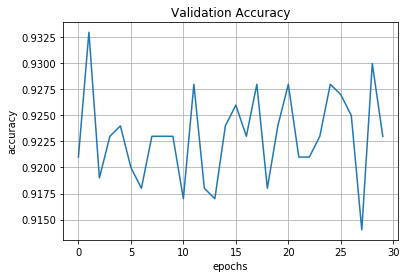

Starting epoch 31 / 50
t = 10, loss = 0.0007
t = 20, loss = 0.0007
t = 30, loss = 0.0004
t = 40, loss = 0.0004
t = 50, loss = 0.0002
t = 60, loss = 0.0007
t = 70, loss = 0.0010
Checking accuracy on validation set
Got 925 / 1000 correct (92.50)


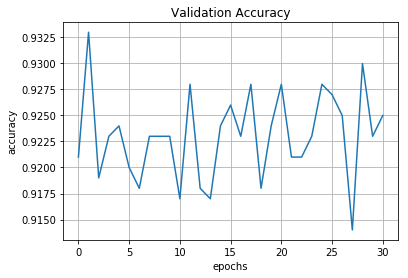

Starting epoch 32 / 50
t = 10, loss = 0.0006
t = 20, loss = 0.0004
t = 30, loss = 0.0006
t = 40, loss = 0.0003
t = 50, loss = 0.0003
t = 60, loss = 0.0003
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 928 / 1000 correct (92.80)


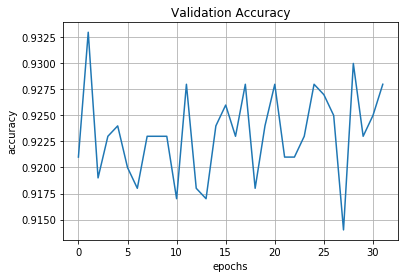

Starting epoch 33 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0004
t = 30, loss = 0.0006
t = 40, loss = 0.0005
t = 50, loss = 0.0004
t = 60, loss = 0.0004
t = 70, loss = 0.0004
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


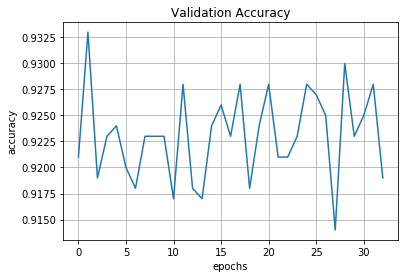

Starting epoch 34 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0010
t = 30, loss = 0.0003
t = 40, loss = 0.0003
t = 50, loss = 0.0002
t = 60, loss = 0.0003
t = 70, loss = 0.0008
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


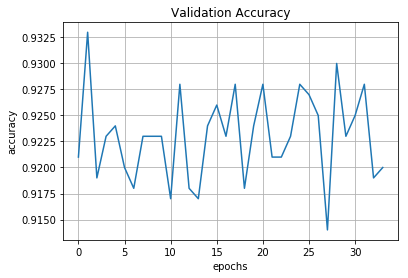

Starting epoch 35 / 50
t = 10, loss = 0.0012
t = 20, loss = 0.0002
t = 30, loss = 0.0004
t = 40, loss = 0.0003
t = 50, loss = 0.0003
t = 60, loss = 0.0003
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 923 / 1000 correct (92.30)


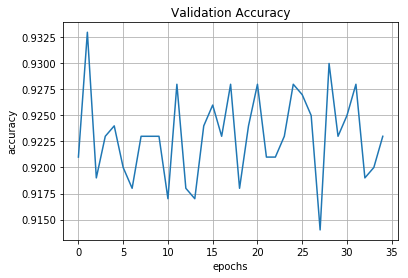

Starting epoch 36 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0005
t = 30, loss = 0.0004
t = 40, loss = 0.0006
t = 50, loss = 0.0005
t = 60, loss = 0.0003
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 915 / 1000 correct (91.50)


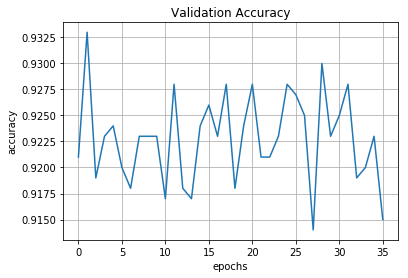

Starting epoch 37 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0005
t = 30, loss = 0.0004
t = 40, loss = 0.0004
t = 50, loss = 0.0005
t = 60, loss = 0.0004
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 917 / 1000 correct (91.70)


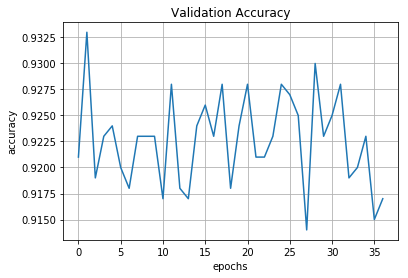

Starting epoch 38 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0003
t = 30, loss = 0.0004
t = 40, loss = 0.0002
t = 50, loss = 0.0004
t = 60, loss = 0.0002
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


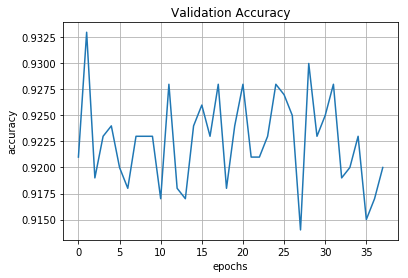

Starting epoch 39 / 50
t = 10, loss = 0.0007
t = 20, loss = 0.0009
t = 30, loss = 0.0004
t = 40, loss = 0.0006
t = 50, loss = 0.0007
t = 60, loss = 0.0003
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 918 / 1000 correct (91.80)


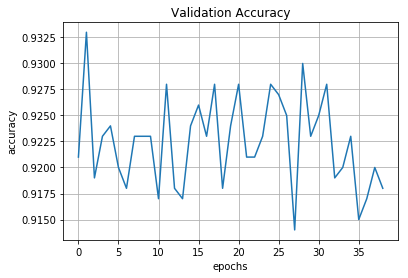

Starting epoch 40 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0004
t = 30, loss = 0.0010
t = 40, loss = 0.0004
t = 50, loss = 0.0008
t = 60, loss = 0.0007
t = 70, loss = 0.0020
Checking accuracy on validation set
Got 917 / 1000 correct (91.70)


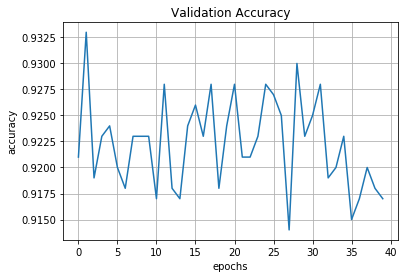

Starting epoch 41 / 50
t = 10, loss = 0.0007
t = 20, loss = 0.0010
t = 30, loss = 0.0003
t = 40, loss = 0.0003
t = 50, loss = 0.0003
t = 60, loss = 0.0002
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


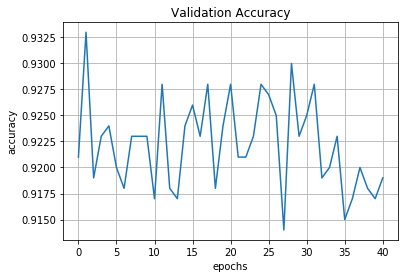

Starting epoch 42 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0004
t = 30, loss = 0.0004
t = 40, loss = 0.0006
t = 50, loss = 0.0018
t = 60, loss = 0.0017
t = 70, loss = 0.0048
Checking accuracy on validation set
Got 920 / 1000 correct (92.00)


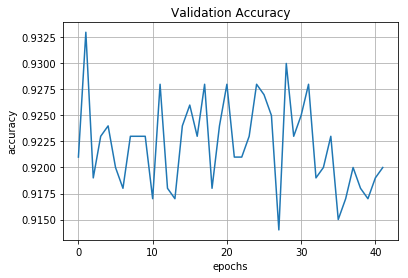

Starting epoch 43 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0004
t = 30, loss = 0.0003
t = 40, loss = 0.0005
t = 50, loss = 0.0002
t = 60, loss = 0.0002
t = 70, loss = 0.0006
Checking accuracy on validation set
Got 928 / 1000 correct (92.80)


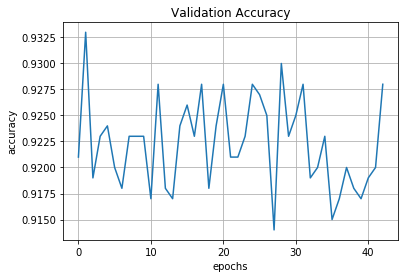

Starting epoch 44 / 50
t = 10, loss = 0.0006
t = 20, loss = 0.0009
t = 30, loss = 0.0003
t = 40, loss = 0.0002
t = 50, loss = 0.0004
t = 60, loss = 0.0003
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 925 / 1000 correct (92.50)


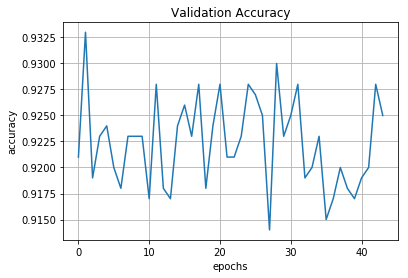

Starting epoch 45 / 50
t = 10, loss = 0.0009
t = 20, loss = 0.0003
t = 30, loss = 0.0010
t = 40, loss = 0.0003
t = 50, loss = 0.0008
t = 60, loss = 0.0005
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 919 / 1000 correct (91.90)


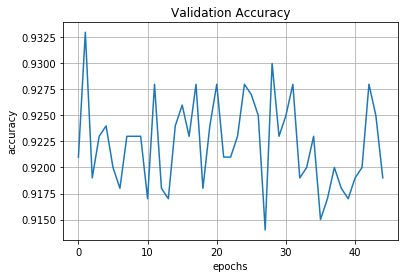

Starting epoch 46 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0005
t = 30, loss = 0.0003
t = 40, loss = 0.0003
t = 50, loss = 0.0003
t = 60, loss = 0.0007
t = 70, loss = 0.0005
Checking accuracy on validation set
Got 913 / 1000 correct (91.30)


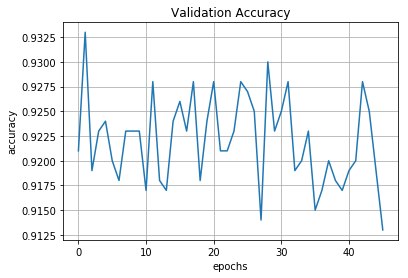

Starting epoch 47 / 50
t = 10, loss = 0.0004
t = 20, loss = 0.0007
t = 30, loss = 0.0004
t = 40, loss = 0.0011
t = 50, loss = 0.0002
t = 60, loss = 0.0003
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 929 / 1000 correct (92.90)


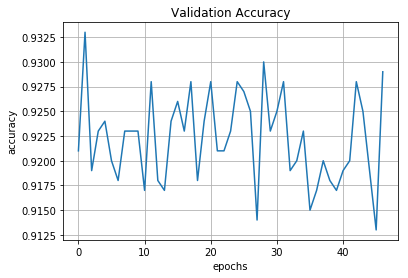

Starting epoch 48 / 50
t = 10, loss = 0.0003
t = 20, loss = 0.0003
t = 30, loss = 0.0004
t = 40, loss = 0.0003
t = 50, loss = 0.0002
t = 60, loss = 0.0014
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 925 / 1000 correct (92.50)


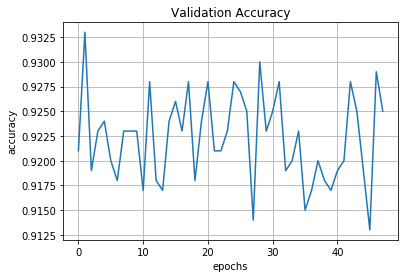

Starting epoch 49 / 50
t = 10, loss = 0.0002
t = 20, loss = 0.0005
t = 30, loss = 0.0005
t = 40, loss = 0.0004
t = 50, loss = 0.0007
t = 60, loss = 0.0003
t = 70, loss = 0.0003
Checking accuracy on validation set
Got 921 / 1000 correct (92.10)


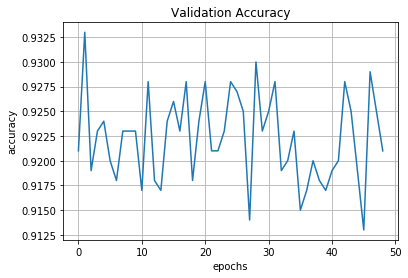

Starting epoch 50 / 50
t = 10, loss = 0.0005
t = 20, loss = 0.0007
t = 30, loss = 0.0011
t = 40, loss = 0.0013
t = 50, loss = 0.0002
t = 60, loss = 0.0003
t = 70, loss = 0.0007
Checking accuracy on validation set
Got 921 / 1000 correct (92.10)


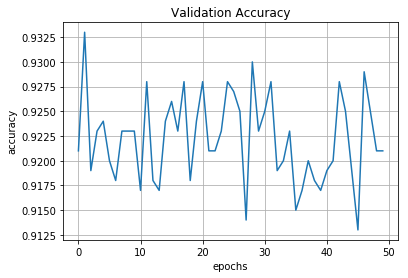

In [13]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4, nesterov=True)

train(model, loss_fn, optimizer, num_epochs=50)

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model).  This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [14]:
best_model = model
test_acc = check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 9202 / 10000 correct (92.02)


## Save checkpoint

Save the best model for re-use.

In [16]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [17]:
save_checkpoint({
            'epoch': 190,
            'arch': 'resnet34',
            'state_dict': model.state_dict(),
            'acc': test_acc,
            'optimizer' : optimizer.state_dict(),
        }, False, 'resnet34-92_02.pth.tar')

In [11]:
def load_checkpoint(filename='checkpoint.pth.tar'):
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        return torch.load(filename)
    else:
        return None

In [12]:
checkpoint = load_checkpoint('resnet34-92_02.pth.tar')
final_model = models.resnet34().type(gpu_dtype)
final_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1).type(gpu_dtype)
final_model.maxpool = Pass().type(gpu_dtype)
final_model.avgpool = nn.AvgPool2d(kernel_size=4, stride=1, padding=0, ceil_mode=False, count_include_pad=True).type(gpu_dtype)
final_model.fc = nn.Linear(512, 10).type(gpu_dtype)
final_model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'resnet34-92_02.pth.tar'


In [13]:
check_accuracy(final_model, loader_test)

Checking accuracy on test set
Got 9250 / 10000 correct (92.50)


0.925